# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)
    - [Maps of per-capita new confirmed/deaths](#us_state_maps)

In [2]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
#plt.style.available
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [2]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [3]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [4]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')

ds_latest = dfp['date'].max().strftime('%Y-%m-%d')
print(f"Latest data from {ds_latest}")

metric: confirmed at 2020-12-19 15:17:08.260632
metric: deaths at 2020-12-19 15:17:13.076796
Latest data from 2020-12-18


In [5]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

# smoothed trend
window_size = 7
dfp_country['deaths_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['deaths_new'].rolling(window_size).mean().reset_index(0,drop=True)
dfp_country['confirmed_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['confirmed_new'].rolling(window_size).mean().reset_index(0,drop=True)

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [6]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-12-18              US   17459296         249709  313588        2814   
1  2020-12-18          Brazil    7162978          52544  185650         823   
2  2020-12-18           India   10004599          25152  145136         347   
3  2020-12-18          Mexico    1301546          12248  117249         762   
4  2020-12-18           Italy    1921778          15401   67894         674   
5  2020-12-18  United Kingdom    1982828          28560   66640         490   
6  2020-12-18          France    2499529          16005   60345         612   
7  2020-12-18            Iran    1145651           7121   53273         178   
8  2020-12-18          Russia    2764843          28116   49170         602   
9  2020-12-18           Spain    1797236          11815   48926         149   
10 2020-12-18       Argentina    1531374           7002   41672         138   
11 2020-12-18        Colombia    1482072          13277   40019         232   
12 2020-12-18            Peru     989457              0   36858           0   
13 2020-12-18         Germany    1486839          32830   25754         727   
14 2020-12-18          Poland    1182864          11010   24771         426   
15 2020-12-18    South Africa     901538           8725   24285         274   
16 2020-12-18       Indonesia     650197           6689   19514         124   
17 2020-12-18         Belgium     621039           2835   18455          84   
18 2020-12-18          Turkey    1982090          26410   17610         246   
19 2020-12-18         Ukraine     970758          13066   16848         269   

    mortality_rate  
0         0.017961  
1         0.025918  
2         0.014507  
3         0.090084  
4         0.035329  
5         0.033609  
6         0.024143  
7         0.046500  
8         0.017784  
9         0.027223  
10        0.027212  
11        0.027002  
12        0.037251  
13        0.017321  
14        0.020942  
15        0.026937  
16        0.030012  
17        0.029716  
18        0.008885  
19        0.017356

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [7]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).reset_index(drop=True).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-18              US   17459296         249709  313588        2814   
1 2020-12-18          Brazil    7162978          52544  185650         823   
2 2020-12-18         Germany    1486839          32830   25754         727   
3 2020-12-18  United Kingdom    1982828          28560   66640         490   
4 2020-12-18          Russia    2764843          28116   49170         602   
5 2020-12-18          Turkey    1982090          26410   17610         246   
6 2020-12-18           India   10004599          25152  145136         347   
7 2020-12-18          France    2499529          16005   60345         612   
8 2020-12-18           Italy    1921778          15401   67894         674   
9 2020-12-18        Colombia    1482072          13277   40019         232   

   mortality_rate  
0        0.017961  
1        0.025918  
2        0.017321  
3        0.033609  
4        0.017784  
5        0.008885  
6        0.014507  
7        0.024143  
8        0.035329  
9        0.027002

In [8]:
dfp_top_countries.sort_values(by='deaths_new', ascending=0).reset_index(drop=True).head(10)



date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-18              US   17459296         249709  313588        2814   
1 2020-12-18          Brazil    7162978          52544  185650         823   
2 2020-12-18          Mexico    1301546          12248  117249         762   
3 2020-12-18         Germany    1486839          32830   25754         727   
4 2020-12-18           Italy    1921778          15401   67894         674   
5 2020-12-18          France    2499529          16005   60345         612   
6 2020-12-18          Russia    2764843          28116   49170         602   
7 2020-12-18  United Kingdom    1982828          28560   66640         490   
8 2020-12-18          Poland    1182864          11010   24771         426   
9 2020-12-18           India   10004599          25152  145136         347   

   mortality_rate  
0        0.017961  
1        0.025918  
2        0.090084  
3        0.017321  
4        0.035329  
5        0.024143  
6        0.017784  
7        0.033609  
8        0.020942  
9        0.014507

In [9]:
dfp_top_countries['deaths_new_frac'] = dfp_top_countries['deaths_new'] / dfp_top_countries['deaths_new'].sum()
dfp_top_countries.sort_values(by='deaths_new', ascending=0).reset_index(drop=True).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-18              US   17459296         249709  313588        2814   
1 2020-12-18          Brazil    7162978          52544  185650         823   
2 2020-12-18          Mexico    1301546          12248  117249         762   
3 2020-12-18         Germany    1486839          32830   25754         727   
4 2020-12-18           Italy    1921778          15401   67894         674   
5 2020-12-18          France    2499529          16005   60345         612   
6 2020-12-18          Russia    2764843          28116   49170         602   
7 2020-12-18  United Kingdom    1982828          28560   66640         490   
8 2020-12-18          Poland    1182864          11010   24771         426   
9 2020-12-18           India   10004599          25152  145136         347   

   mortality_rate  deaths_new_frac  
0        0.017961         0.222662  
1        0.025918         0.065121  
2        0.090084         0.060294  
3        0.017321         0.057525  
4        0.035329         0.053331  
5        0.024143         0.048425  
6        0.017784         0.047634  
7        0.033609         0.038772  
8        0.020942         0.033708  
9        0.014507         0.027457

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [10]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

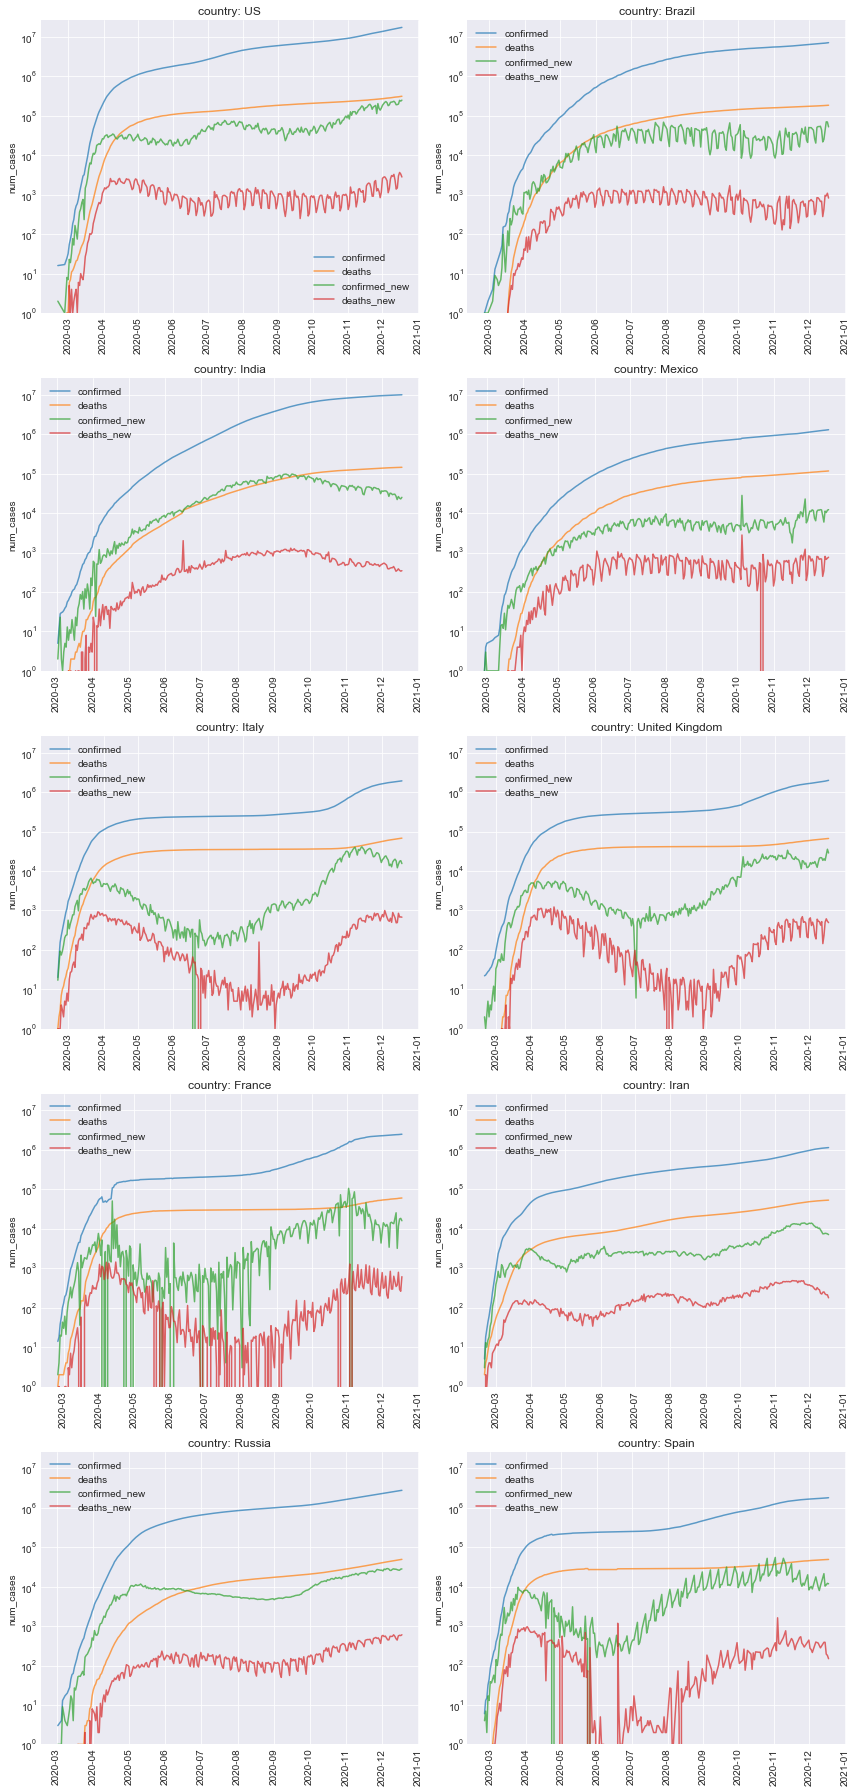

In [11]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

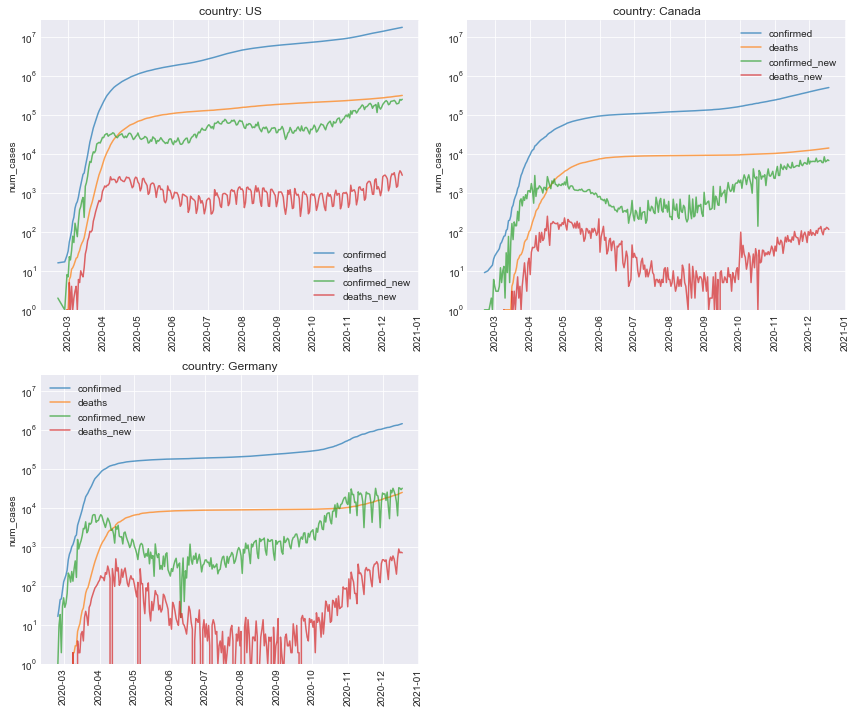

In [12]:
plot_countries(dfp_country, 
               countries=['US', 'Canada', 'Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [13]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

In [14]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_1)

confirmed_pred                         deaths_pred             \
date               2020-12-19  2020-12-25  2021-01-08  2020-12-19 2020-12-25   
country                                                                        
US                 17661910.0  19103473.0  22941399.0    315868.0   333329.0   
Brazil              7197692.0   7507449.0   8283049.0    186260.0   191188.0   
India              10029542.0  10178621.0  10535147.0    145507.0   147679.0   
Mexico              1309479.0   1372891.0   1533052.0    117692.0   121507.0   
Italy               1937630.0   2038968.0   2296516.0     68548.0    72798.0   
United Kingdom      2001459.0   2161426.0   2586182.0     66977.0    69767.0   
France              2511868.0   2603118.0   2829135.0     60784.0    63619.0   
Iran                1153724.0   1200961.0   1318840.0     53537.0    54907.0   
Russia              2792578.0   2966120.0   3414157.0     49683.0    53213.0   
Spain               1809368.0   1883721.0   2069312.0     49258.0    50767.0   

                          mortality_rate_pred                        \
date           2021-01-08          2020-12-19 2020-12-25 2021-01-08   
country                                                               
US               377916.0            0.017884   0.017449   0.016473   
Brazil           203200.0            0.025878   0.025466   0.024532   
India            152873.0            0.014508   0.014509   0.014511   
Mexico           130898.0            0.089877   0.088504   0.085384   
Italy             83767.0            0.035377   0.035703   0.036476   
United Kingdom    76737.0            0.033464   0.032278   0.029672   
France            70757.0            0.024199   0.024440   0.025010   
Iran              58242.0            0.046404   0.045719   0.044162   
Russia            62456.0            0.017791   0.017940   0.018293   
Spain             54471.0            0.027224   0.026950   0.026323   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.013163             0.009008  
Brazil                        0.007047             0.004362  
India                         0.002462             0.002472  
Mexico                        0.007913             0.005331  
Italy                         0.008533             0.010075  
United Kingdom                0.012898             0.006825  
France                        0.005965             0.007625  
Iran                          0.006710             0.004221  
Russia                        0.010099             0.011506  
Spain                         0.006735             0.005042

In [15]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-12-18_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [16]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


In [17]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
#find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

In [18]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_2)

confirmed_pred             deaths_pred             \
date               2020-12-19  2020-12-25  2020-12-19 2020-12-25   
country                                                            
US                 17691788.0  19182706.0    315385.0   331942.0   
Brazil              7186199.0   7474129.0    185912.0   190219.0   
India              10043921.0  10215827.0    145635.0   148009.0   
Mexico              1312031.0   1380005.0    117724.0   121565.0   
Italy               1940699.0   2048312.0     68603.0    72946.0   
United Kingdom      1988234.0   2125776.0     66970.0    69723.0   
France              2504531.0   2582548.0     60689.0    63284.0   
Iran                1160741.0   1218924.0     53682.0    55271.0   
Russia              2797520.0   2979552.0     49744.0    53378.0   
Spain               1797750.0   1851225.0     49191.0    50548.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-12-19 2020-12-25                           
country                                                                 
US                        0.017827   0.017304                0.013576   
Brazil                    0.025871   0.025450                0.006569   
India                     0.014500   0.014488                0.002832   
Mexico                    0.089727   0.088090                0.008454   
Italy                     0.035350   0.035613                0.009035   
United Kingdom            0.033683   0.032799                0.011211   
France                    0.024232   0.024504                0.005126   
Iran                      0.046248   0.045344                0.008185   
Russia                    0.017781   0.017915                0.010562   
Spain                     0.027363   0.027305                0.004897   

               frac_increase_deaths  
date                                 
country                              
US                         0.008564  
Brazil                     0.003825  
India                      0.002699  
Mexico                     0.005365  
Italy                      0.010283  
United Kingdom             0.006738  
France                     0.007003  
Iran                       0.004873  
Russia                     0.011822  
Spain                      0.004548

In [19]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-12-18_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [20]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [21]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [22]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [23]:
# plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [24]:
dfp_3codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
dfp_3codes.columns = list([x.lower() for x in dfp_3codes.columns])
dfp_3codes = dfp_3codes.rename(columns={'code': 'country_code'})

In [25]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})

# decorate with country codes
dfp_demo_decade = dfp_demo_decade.merge(dfp_3codes[['country', 'country_code']], on='country', how='left')

# ensure consistency with Johns Hopkins data
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']

grouping_cols_country = ['country', 'country_code']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(grouping_cols_country, as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

In [26]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']
# for country in countries:
#     dfp_plot = dfp_demo[dfp_demo.country == country]
#     plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
# plt.xlabel('age')
# plt.ylabel('% of population')
# plt.title('Age distribution by country')
# plt.legend(loc='best')
# plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

In [27]:
# n_countries = 10
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
# dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
#                            (dfp_country['country'].isin(countries))
#                           ].
#                sort_values(by='mortality_rate', ascending=0).
#                reset_index(drop=True)
#               )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
# display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

In [28]:
# dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
# plt.title('Distribution of mortality fraction')
# plt.ylabel('number of countries')
# plt.xlabel('mortality fraction')
# plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [29]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country country_code  frac_mortality  num_deaths_max_expected  \
1         Japan          JPN        0.031837              3998380.024   
2       Germany          DEU        0.026398              2128411.026   
3        Greece          GRC        0.025745               271233.247   
4         Italy          ITA        0.025637              1599267.592   
10     Portugal          PRT        0.023736               244829.259   
18       France          FRA        0.022950              1564984.503   
20       Sweden          SWE        0.022575               231555.716   
23      Belgium          BEL        0.022146               259573.363   
24  Netherlands          NLD        0.022076               382222.125   
27       Canada          CAN        0.021712               820035.480   

          pop  
1   125507472  
2    80159662  
3    10607051  
4    62402659  
10   10302674  
18   67848156  
20   10202491  
23   11720716  
24   17280397  
27   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [30]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[grouping_cols_country + ['pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

# new infections
dfp_country_pop['deaths_new_per_million'] = dfp_country_pop['deaths_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million'] = dfp_country_pop['confirmed_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['deaths_new_per_million_smooth'] = dfp_country_pop['deaths_new_smooth'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million_smooth'] = dfp_country_pop['confirmed_new_smooth'] / dfp_country_pop['pop'] * 1E6

### Map: new confirmed cases and deaths

In [31]:
def plot_world_map(df, plot_col, color='Reds', col_country='country_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_country], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        #locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        #geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [32]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'confirmed_new_per_million_smooth')

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In [33]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'deaths_new_per_million_smooth')

In [34]:
def plot_smoothed_trend(
    dfp_us_g, 
    states, 
    cols_plot=['confirmed_new'], 
    dt_start=datetime.datetime(2020,3,1), 
    state_col='state'
):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g[state_col] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

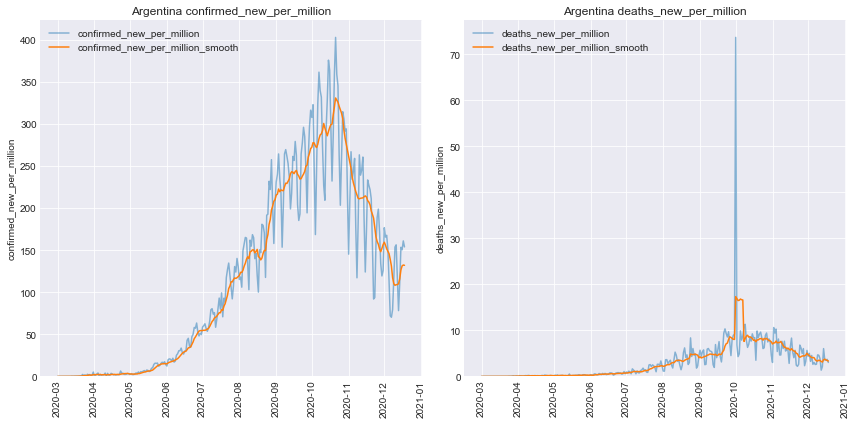

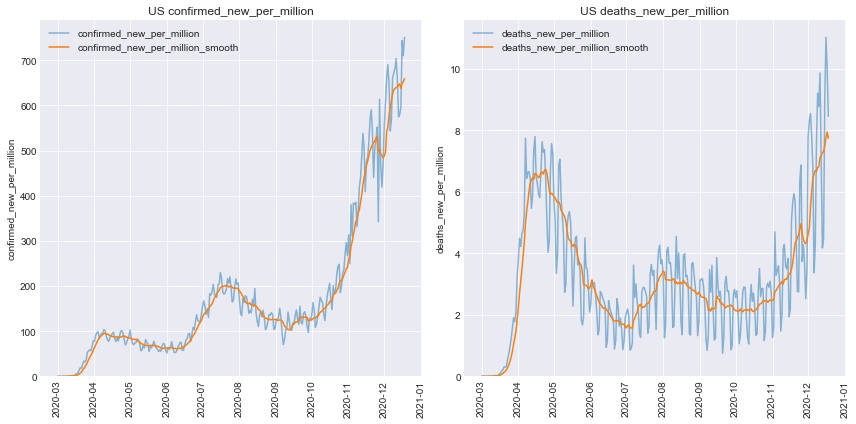

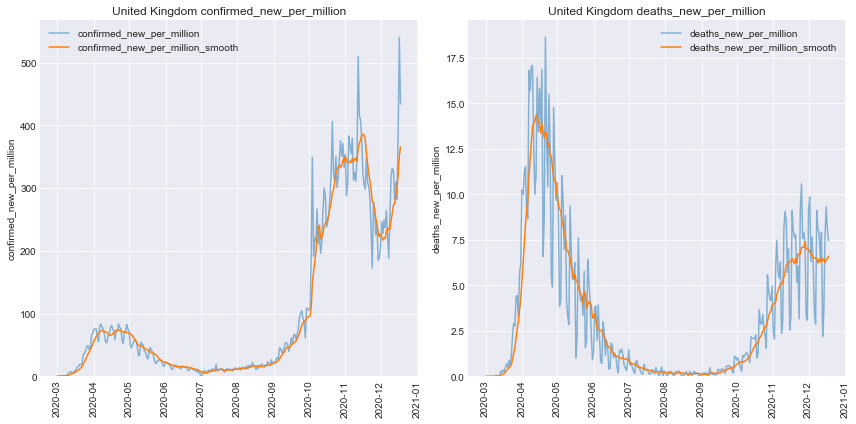

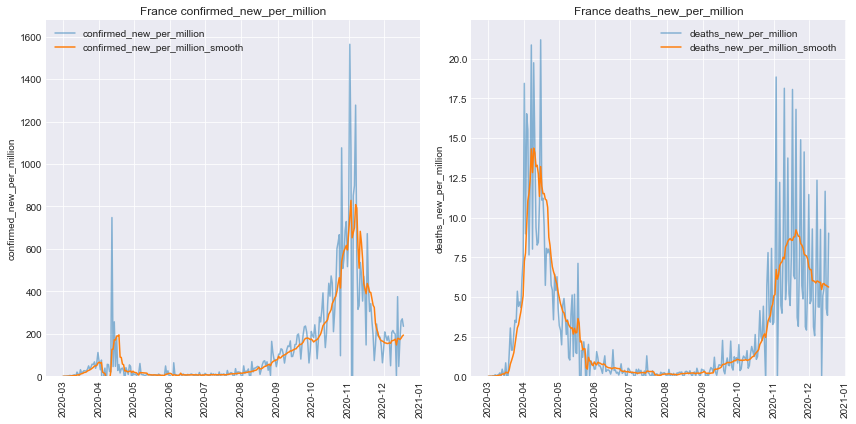

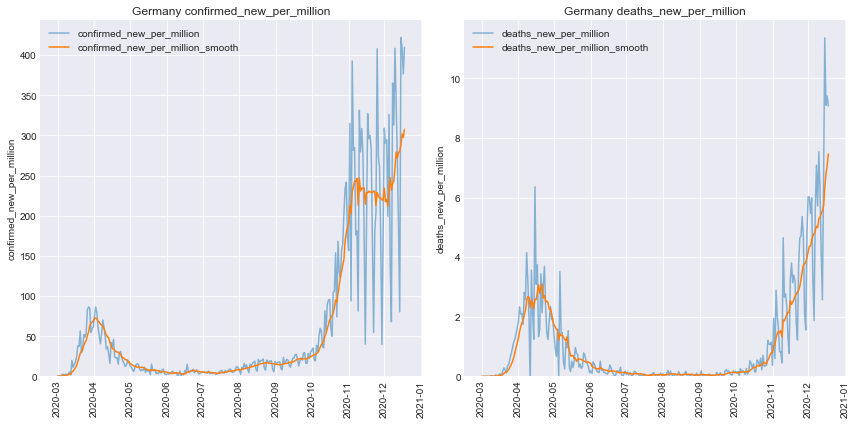

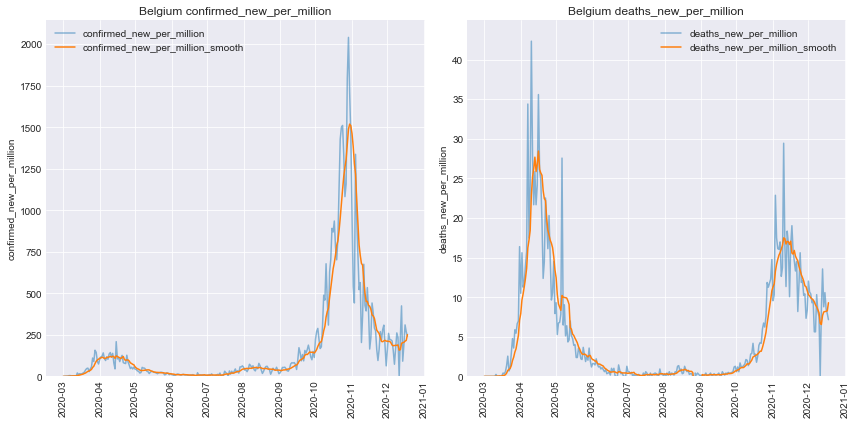

In [35]:
plot_smoothed_trend(
    dfp_country_pop, 
    state_col='country', 
    states=['Argentina', 'US', 'United Kingdom', 'France', 'Germany', 'Belgium'], 
    cols_plot=['confirmed_new_per_million', 'deaths_new_per_million']
)

##### Top countries by per-capita

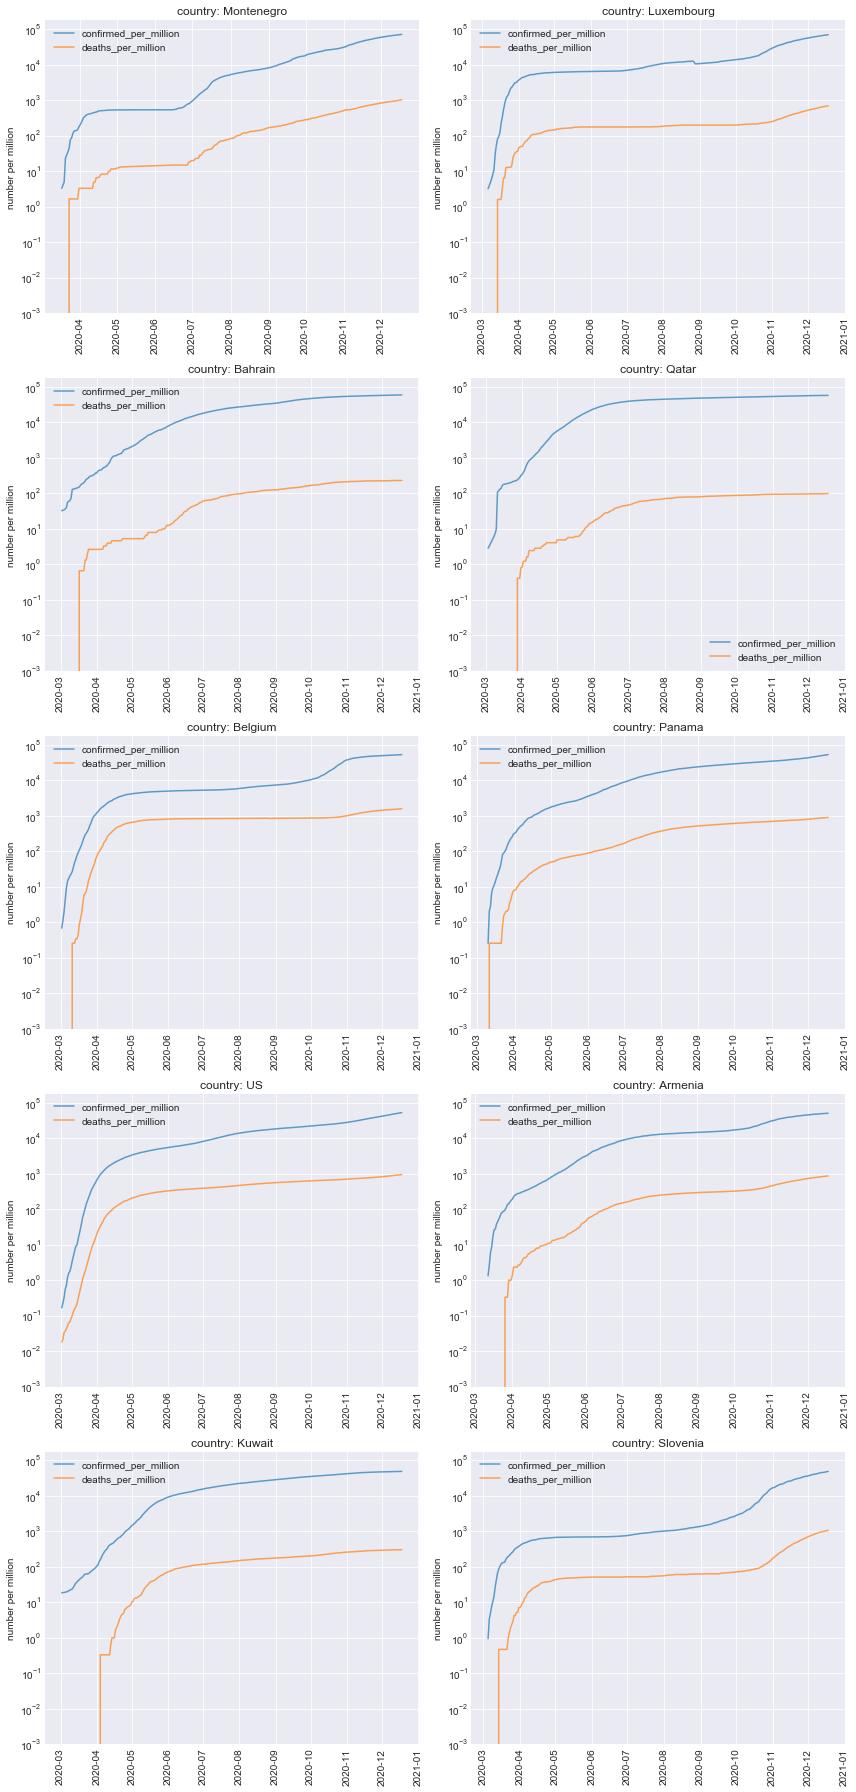

country   population   confirmed    deaths  confirmed_per_million  \
0  Montenegro     609859.0     43390.0     620.0           71147.593132   
1  Luxembourg     628381.0     43728.0     434.0           69588.354836   
2     Bahrain    1505003.0     89883.0     349.0           59722.804539   
3       Qatar    2444174.0    141716.0     242.0           57981.142095   
4     Belgium   11720716.0    621039.0   18455.0           52986.438712   
5      Panama    3894082.0    206310.0    3504.0           52980.394352   
6          US  332639102.0  17459296.0  313588.0           52487.202782   
7     Armenia    3021324.0    152253.0    2596.0           50392.807921   
8      Kuwait    2993706.0    147531.0     916.0           49280.390259   
9    Slovenia    2102678.0    103555.0    2274.0           49249.100433   

   deaths_per_million  mortality_rate  
0         1016.628434        0.014289  
1          690.663785        0.009925  
2          231.893225        0.003883  
3           99.010954        0.001708  
4         1574.562510        0.029716  
5          899.826968        0.016984  
6          942.727413        0.017961  
7          859.225955        0.017051  
8          305.975269        0.006209  
9         1081.478001        0.021959

In [36]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [37]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop   confirmed    deaths  \
4                  Belgium   11720716.0    621039.0   18455.0   
28                    Peru   31914989.0    989457.0   36858.0   
31                   Italy   62402659.0   1921778.0   67894.0   
9                 Slovenia    2102678.0    103555.0    2274.0   
0               Montenegro     609859.0     43390.0     620.0   
34          United Kingdom   65761117.0   1982828.0   66640.0   
21                   Spain   50015792.0   1797236.0   48926.0   
6                       US  332639102.0  17459296.0  313588.0   
37  Bosnia and Herzegovina    3835586.0    104881.0    3583.0   
38                Bulgaria    6966899.0    190027.0    6496.0   

    confirmed_per_million  deaths_per_million  mortality_rate  
4            52986.438712         1574.562510        0.029716  
28           31002.893343         1154.880548        0.037251  
31           30796.412057         1087.998510        0.035329  
9            49249.100433         1081.478001        0.021959  
0            71147.593132         1016.628434        0.014289  
34           30151.981755         1013.364782        0.033609  
21           35933.370804          978.211042        0.027223  
6            52487.202782          942.727413        0.017961  
37           27344.191996          934.146699        0.034163  
38           27275.693246          932.409096        0.034185

### Mortality rate by deaths per capita, confirmed per capita

In [38]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='deaths_per_million', 
#                                   y_col='mortality_rate'
#                                  )

In [39]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='confirmed_per_million', 
#                                   y_col='mortality_rate'
#                                  )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [40]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

In [41]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

In [42]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [43]:
# # load and clean data
# dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
# dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
#                                         'positive': 'confirmed',
#                                         'death': 'deaths',
#                                         'date': 'date_str'
#                                        })
# dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# dfp_us_raw['country'] = 'US'

In [44]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered', 'people_hospitalized']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update',
                      'People_Hospitalized': 'people_hospitalized'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    
    dfp_temp['date'] = datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
    #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [45]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')
# dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
# dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# # aggregate infections by state
# dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
#             agg({
#                 'confirmed': np.sum,
#                 'deaths': np.sum,
#                 #'recovered': np.sum,
#                })
#            )
# dfp_us_g.shape

In [46]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [47]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)


date           state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-12-18        New York     828166          12697   36177         125   
1  2020-12-18           Texas    1569032          17283   25522         345   
2  2020-12-18      California    1802195          48221   22370         276   
3  2020-12-18         Florida    1181483          13000   20401          96   
4  2020-12-18      New Jersey     423226           3896   18124          44   
5  2020-12-18        Illinois     886805           7377   16206         221   
6  2020-12-18    Pennsylvania     544116           9168   13549         220   
7  2020-12-18        Michigan     491875           4519   11868          67   
8  2020-12-18   Massachusetts     314926           5679   11610          52   
9  2020-12-18         Georgia     576537           8141   10332          38   
10 2020-12-18            Ohio     605862           9684    7967          73   
11 2020-12-18         Arizona     442671           7635    7819         142   
12 2020-12-18         Indiana     453139           5949    7265          85   
13 2020-12-18       Louisiana     282434           3113    6994          30   
14 2020-12-18  North Carolina     466104           8444    6125          60   

    mortality_rate  
0         0.043683  
1         0.016266  
2         0.012413  
3         0.017267  
4         0.042823  
5         0.018275  
6         0.024901  
7         0.024128  
8         0.036866  
9         0.017921  
10        0.013150  
11        0.017663  
12        0.016033  
13        0.024763  
14        0.013141

In [48]:
dfp_us_top_states.sort_values(by='deaths_new', ascending=0).head(15)

date           state  confirmed  confirmed_new  deaths  deaths_new  \
1  2020-12-18           Texas    1569032          17283   25522         345   
2  2020-12-18      California    1802195          48221   22370         276   
5  2020-12-18        Illinois     886805           7377   16206         221   
6  2020-12-18    Pennsylvania     544116           9168   13549         220   
11 2020-12-18         Arizona     442671           7635    7819         142   
0  2020-12-18        New York     828166          12697   36177         125   
15 2020-12-18       Tennessee     503651          10421    5960         115   
3  2020-12-18         Florida    1181483          13000   20401          96   
31 2020-12-18          Kansas     203585           5654    2341          88   
12 2020-12-18         Indiana     453139           5949    7265          85   
10 2020-12-18            Ohio     605862           9684    7967          73   
21 2020-12-18       Wisconsin     486364           3921    4632          71   
7  2020-12-18        Michigan     491875           4519   11868          67   
20 2020-12-18       Minnesota     391889           2718    4782          65   
14 2020-12-18  North Carolina     466104           8444    6125          60   

    mortality_rate  
1         0.016266  
2         0.012413  
5         0.018275  
6         0.024901  
11        0.017663  
0         0.043683  
15        0.011834  
3         0.017267  
31        0.011499  
12        0.016033  
10        0.013150  
21        0.009524  
7         0.024128  
20        0.012202  
14        0.013141

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [49]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

In [50]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

In [51]:
# plot_countries(dfp_us_g, 
#                countries=dfp_us_top_states.iloc[:10]['state'].values,
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

In [52]:
# plot_countries(dfp_us_g, 
#                countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

In [53]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_1, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-19 2020-12-25 2021-01-08  2020-12-19 2020-12-25   
state                                                                       
New York            837718.0   906256.0  1088783.0     36276.0    36956.0   
Texas              1584613.0  1693446.0  1977348.0     25591.0    26874.0   
California         1841559.0  2146225.0  3067736.0     22565.0    24191.0   
Florida            1189966.0  1258399.0  1433773.0     20513.0    21164.0   
New Jersey          428425.0   457884.0   534739.0     18201.0    18655.0   
Illinois            894375.0   942397.0  1064716.0     16311.0    17354.0   
Pennsylvania        555492.0   623130.0   814731.0     13726.0    15103.0   
Michigan            497131.0   528072.0   607966.0     12001.0    12817.0   
Massachusetts       319270.0   351551.0   440144.0     11661.0    11982.0   
Georgia             581491.0   623396.0   733296.0     10372.0    10666.0   

                         mortality_rate_pred                        \
date          2021-01-08          2020-12-19 2020-12-25 2021-01-08   
state                                                                
New York         38594.0            0.043303   0.040779   0.035447   
Texas            30125.0            0.016150   0.015869   0.015235   
California       28456.0            0.012253   0.011271   0.009276   
Florida          22763.0            0.017238   0.016818   0.015876   
New Jersey       19760.0            0.042484   0.040742   0.036953   
Illinois         20055.0            0.018237   0.018415   0.018836   
Pennsylvania     18880.0            0.024710   0.024237   0.023173   
Michigan         14941.0            0.024141   0.024271   0.024575   
Massachusetts    12766.0            0.036524   0.034083   0.029004   
Georgia          11386.0            0.017837   0.017110   0.015527   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.013193             0.003102  
Texas                        0.011132             0.008189  
California                   0.025845             0.011664  
Florida                      0.009363             0.005217  
New Jersey                   0.011145             0.004118  
Illinois                     0.008755             0.010387  
Pennsylvania                 0.019335             0.016068  
Michigan                     0.010114             0.011014  
Massachusetts                0.016183             0.004537  
Georgia                      0.011665             0.004674

##### 2 weeks of data

In [54]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_2, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-19 2020-12-25 2021-01-08  2020-12-19 2020-12-25   
state                                                                       
New York            838423.0   908437.0  1095388.0     36215.0    36802.0   
Texas              1579893.0  1679418.0  1936710.0     25533.0    26711.0   
California         1821133.0  2085359.0  2860698.0     22353.0    23597.0   
Florida            1188636.0  1255040.0  1424770.0     20512.0    21158.0   
New Jersey          429923.0   462067.0   546728.0     18176.0    18584.0   
Illinois            898788.0   954326.0  1097631.0     16375.0    17525.0   
Pennsylvania        559959.0   636209.0   856975.0     13685.0    14986.0   
Michigan            499807.0   534599.0   625491.0     12017.0    12864.0   
Massachusetts       320688.0   355742.0   453164.0     11661.0    11980.0   
Georgia             580535.0   620808.0   725981.0     10354.0    10616.0   

                         mortality_rate_pred                        \
date          2021-01-08          2020-12-19 2020-12-25 2021-01-08   
state                                                                
New York         38207.0            0.043194   0.040511   0.034880   
Texas            29675.0            0.016161   0.015905   0.015322   
California       26777.0            0.012274   0.011316   0.009360   
Florida          22744.0            0.017257   0.016858   0.015963   
New Jersey       19572.0            0.042277   0.040219   0.035798   
Illinois         20531.0            0.018219   0.018364   0.018705   
Pennsylvania     18523.0            0.024439   0.023555   0.021614   
Michigan         15078.0            0.024043   0.024063   0.024106   
Massachusetts    12759.0            0.036362   0.033676   0.028155   
Georgia          11253.0            0.017835   0.017100   0.015500   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.013457             0.002680  
Texas                        0.010234             0.007546  
California                   0.022837             0.009069  
Florida                      0.009101             0.005176  
New Jersey                   0.012090             0.003706  
Illinois                     0.010043             0.011373  
Pennsylvania                 0.021505             0.015253  
Michigan                     0.011279             0.011408  
Massachusetts                0.017440             0.004510  
Georgia                      0.011241             0.004174

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [55]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [56]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'confirmed_new', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  confirmed_new  \
0  2020-12-18                Oregon     100308    1304           1372   
1  2020-12-18               Vermont       6243     107             94   
2  2020-12-18         West Virginia      69751    1091           1266   
3  2020-12-18                Kansas     203585    2341           5654   
4  2020-12-18            New Mexico     127500    2128           1455   
5  2020-12-18               Wyoming      41359     351            766   
6  2020-12-18              Colorado     304107    4259           3693   
7  2020-12-18             Tennessee     503651    5960          10421   
8  2020-12-18                 Maine      18337     281            436   
9  2020-12-18              Missouri     369241    4978           3563   
10 2020-12-18          Pennsylvania     544116   13549           9168   
11 2020-12-18                  Utah     246562    1140           2644   
12 2020-12-18                 Idaho     128218    1275           1340   
13 2020-12-18                  Iowa     264707    3450           2497   
14 2020-12-18             Minnesota     391889    4782           2718   
15 2020-12-18              Arkansas     197421    3139           2878   
16 2020-12-18          Rhode Island      77812    1625            522   
17 2020-12-18               Indiana     453139    7265           5949   
18 2020-12-18              Nebraska     154745    1470           1345   
19 2020-12-18                Nevada     199257    2706           2878   
20 2020-12-18            California    1802195   22370          48221   
21 2020-12-18                  Ohio     605862    7967           9684   
22 2020-12-18             Wisconsin     486364    4632           3921   
23 2020-12-18          South Dakota      93772    1329            575   
24 2020-12-18               Arizona     442671    7819           7635   
25 2020-12-18         New Hampshire      34960     638            696   
26 2020-12-18            Washington     220268    3104           3063   
27 2020-12-18              Kentucky     237189    2344           3169   
28 2020-12-18          North Dakota      89554    1225            491   
29 2020-12-18              Michigan     491875   11868           4519   
30 2020-12-18              Illinois     886805   16206           7377   
31 2020-12-18        North Carolina     466104    6125           8444   
32 2020-12-18              Oklahoma     251760    2161           3556   
33 2020-12-18           Puerto Rico      66132    1333           1381   
34 2020-12-18              Maryland     246553    5358           2569   
35 2020-12-18                Alaska      43352     183            496   
36 2020-12-18              Virginia     299388    4598           3295   
37 2020-12-18              Delaware      49109     854            341   
38 2020-12-18               Montana      75992     854            509   
39 2020-12-18                 Texas    1569032   25522          17283   
40 2020-12-18               Alabama     315683    4296           5348   
41 2020-12-18           Mississippi     190411    4354           2507   
42 2020-12-18           Connecticut     162782    5581           2680   
43 2020-12-18             Louisiana     282434    6994           3113   
44 2020-12-18        South Carolina     267076    4872           4302   
45 2020-12-18                Hawaii      20223     281            156   
46 2020-12-18                  Guam       7193     119             10   
47 2020-12-18               Florida    1181483   20401          13000   
48 2020-12-18         Massachusetts     314926   11610           5679   
49 2020-12-18               Georgia     576537   10332           8141   
50 2020-12-18            New Jersey     423226   18124           3896   
51 2020-12-18              New York     828166   36177          12697   
52 2020-12-18  District of Columbia      26104     728            274   
53 2020-12-18        Virgin Islands       1900      23             

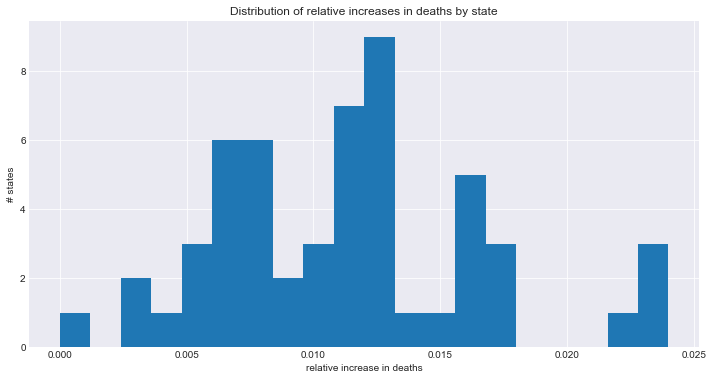

In [57]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

In [58]:
# plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
# #plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('relative increase in deaths per day')
# plt.ylabel('# deaths')
# plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
# plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [59]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

In [60]:
# _ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'Washington', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

In [61]:
# _ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'New York', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

In [62]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

#plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

In [63]:
#plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

In [64]:
#find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [65]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                        n_countries=10, 
                        n_columns=2, 
                        figsize=(12,24), 
                        date_min=datetime.datetime(2020, 2, 1),
                        col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                       frac_increase_col='frac_increase_deaths',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs[frac_increase_col].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [66]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-12-19 2020-12-25 2021-01-01 2021-01-15   
state                                                                      
California                        44216      62701      94244     212920   
Texas                             16304      17968      20126      25251   
New York                          11756      13786      16602      24078   
Pennsylvania                      11704      13665      16371      23500   
Florida                           10870      11922      13278      16473   
Illinois                           8284       7943       7563       6857   
Georgia                            7295       9360      12521      22402   
Massachusetts                      6109       7619       9859      16508   
New Jersey                         5116       5455       5878       6825   
Michigan                           4727       4082       3439       2441   

                                                                      \
date          2021-02-12 2021-03-12 2021-04-09 2021-05-07 2021-06-04   
state                                                                  
California       1086766    5546966   28312276  144508717  737587083   
Texas              39746      62563      98477     155009     243992   
New York           50644     106519     224039     471216     991099   
Pennsylvania       48419      99763     205551     423516     872607   
Florida            25352      39016      60045      92409     142217   
Illinois            5637       4633       3809       3131       2573   
Georgia            71710     229552     734817    2352212    7529630   
Massachusetts      46282     129758     363791    1019928    2859480   
New Jersey          9202      12407      16729      22555      30411   
Michigan            1230        620        312        157         79   

                           deaths_new_smooth_pred                        \
date            2021-07-30             2020-12-19 2020-12-25 2021-01-01   
state                                                                     
California     19215505441                    252        384        627   
Texas               604525                    205        236        277   
New York           4384401                    120        168        248   
Pennsylvania       3704389                    243        340        505   
Florida             336838                    112        126        143   
Illinois              1739                    190        210        237   
Georgia           77155683                     45         46         48   
Massachusetts     22476131                     58         71         88   
New Jersey           55283                     77         98        131   
Michigan                20                    141        158        181   

                                                                      \
date          2021-01-15 2021-02-12 2021-03-12 2021-04-09 2021-05-07   
state                                                                  
California          1674      11917      84825     603786    4297749   
Texas                384        736       1410       2701       5172   
New York             541       2571      12212      58003     275498   
Pennsylvania        1112       5381      26036     125972     609492   
Florida              186        315        532        898       1516   
Illinois             300        480        769       1232       1974   
Georgia               51         58         66         76         86   
Massachusetts        137        333        804       1944       4697   
New Jersey           233        732       2299       7219      22666   
Michigan             237        406        695       1192       2042   

                                     frac_increase_confirmed  \
date          2021-06-04  2021-07-30                           
state                                          

In [67]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

##### Fraction of increase in confirmed cases

In [68]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_confirmed'
# )

##### Fraction increase in deaths_new

In [69]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_deaths'
# )

In [70]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-12-18_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [71]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

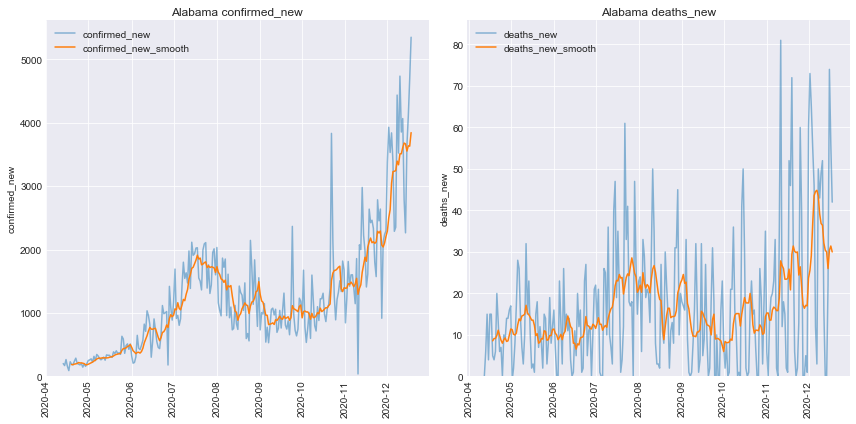

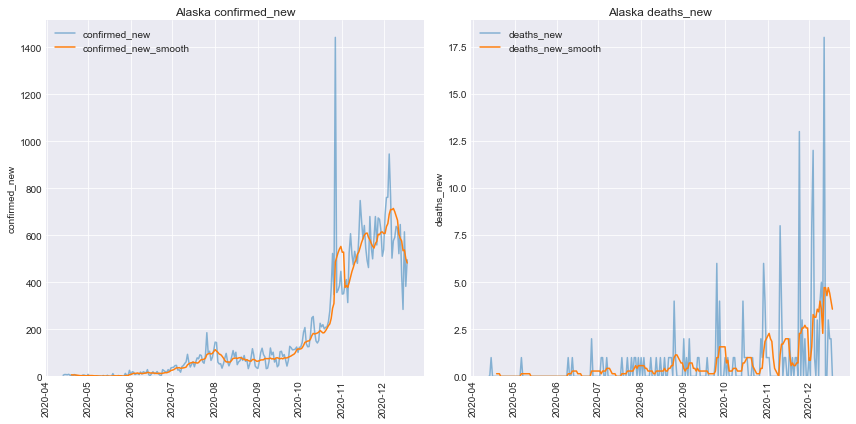

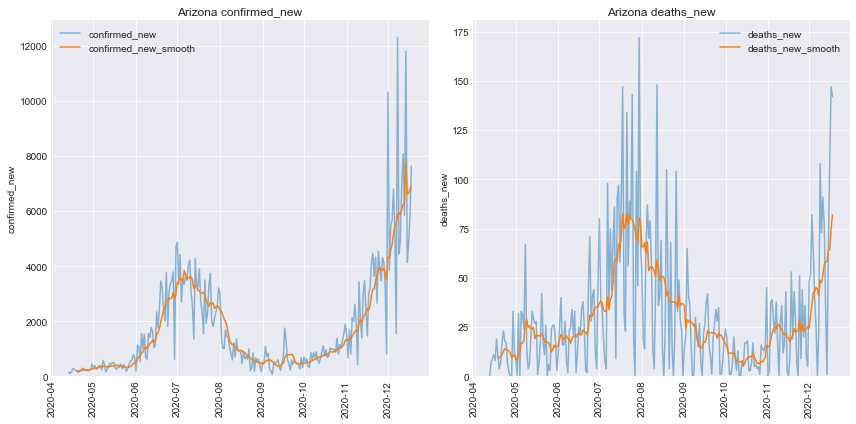

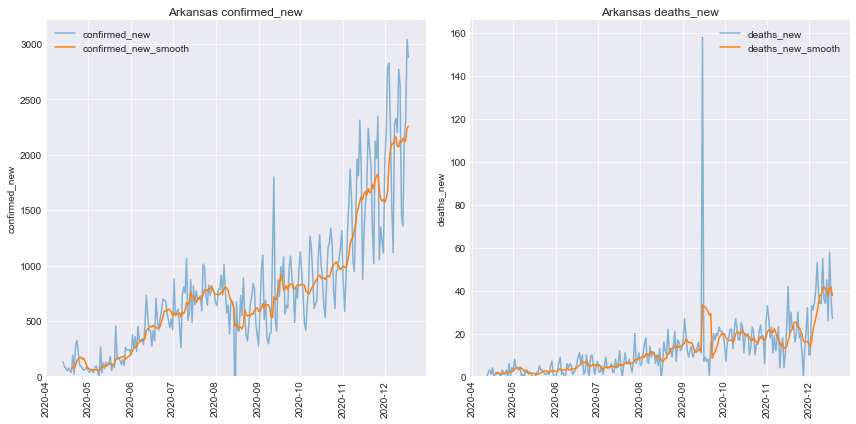

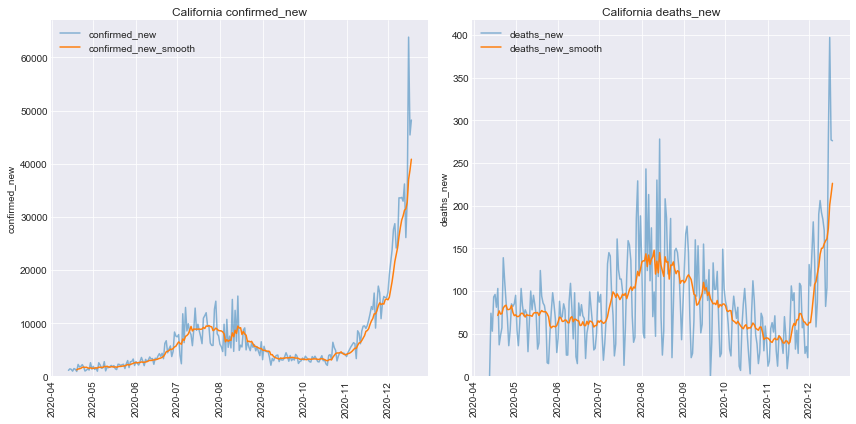

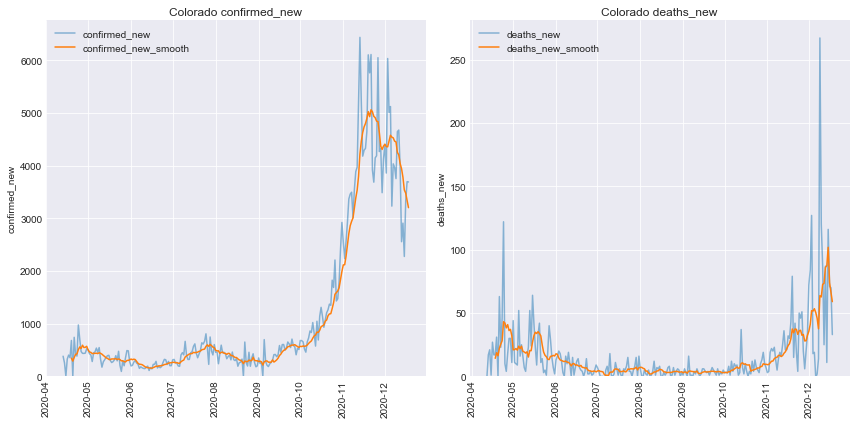

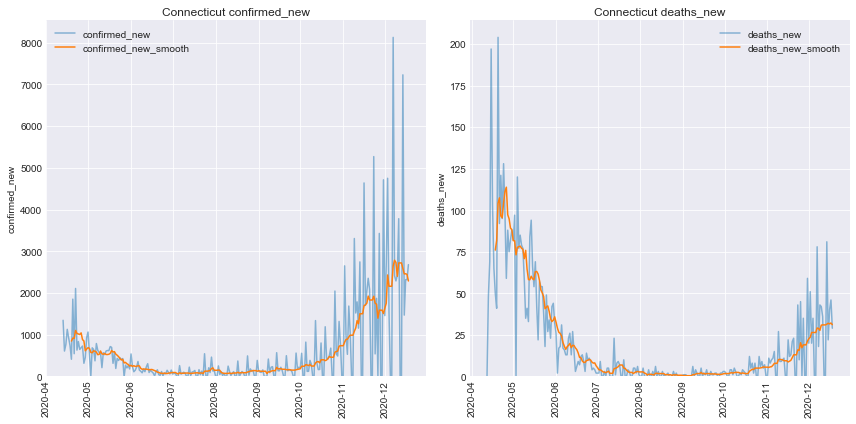

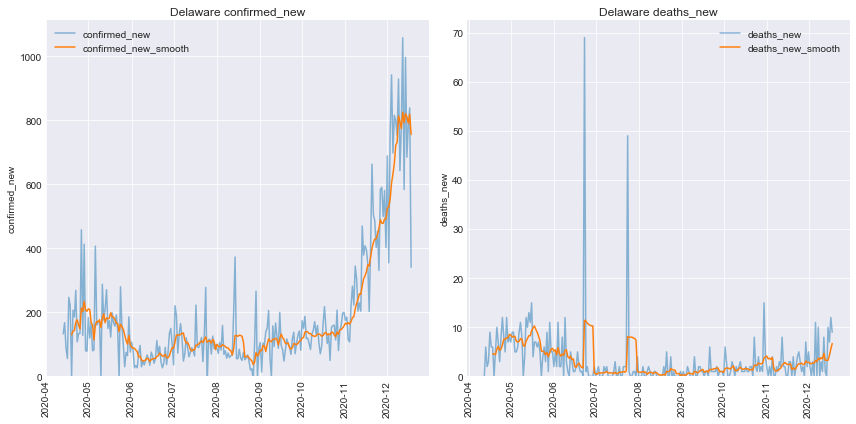

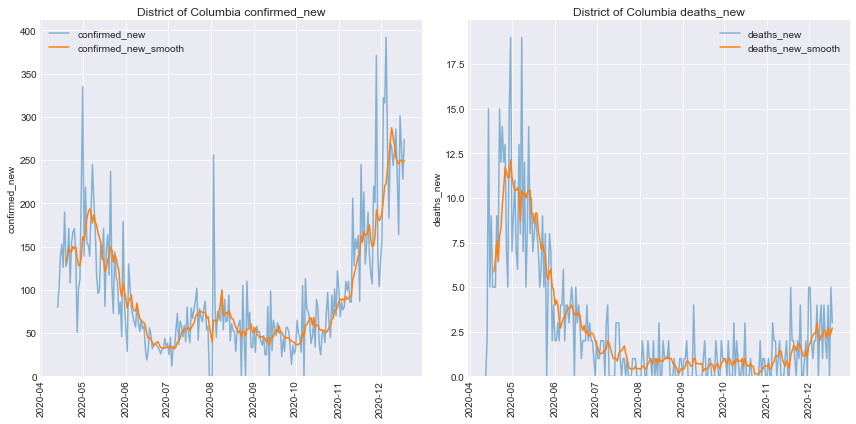

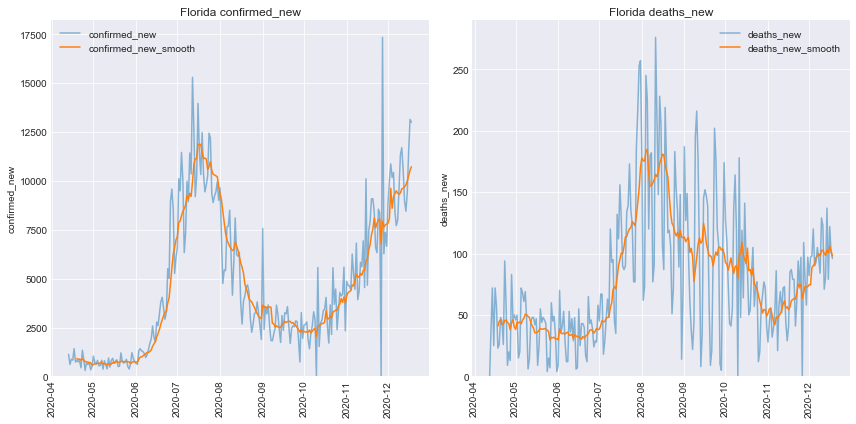

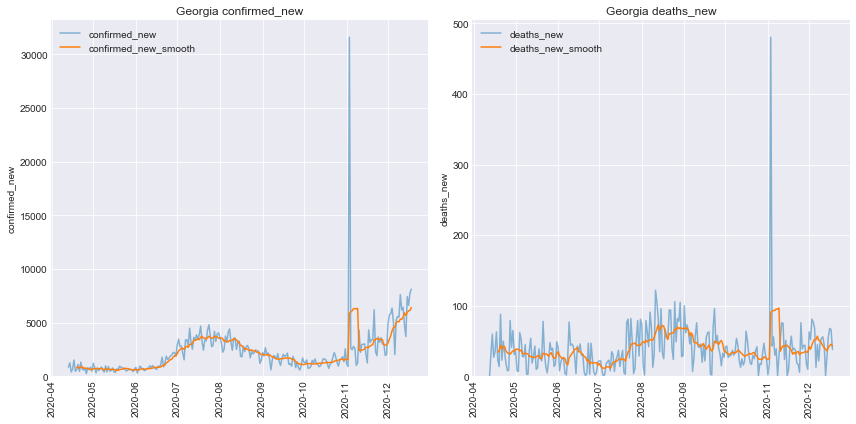

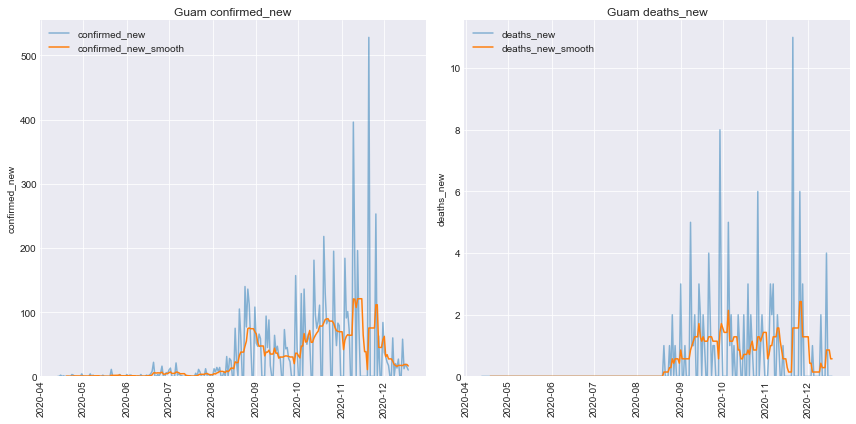

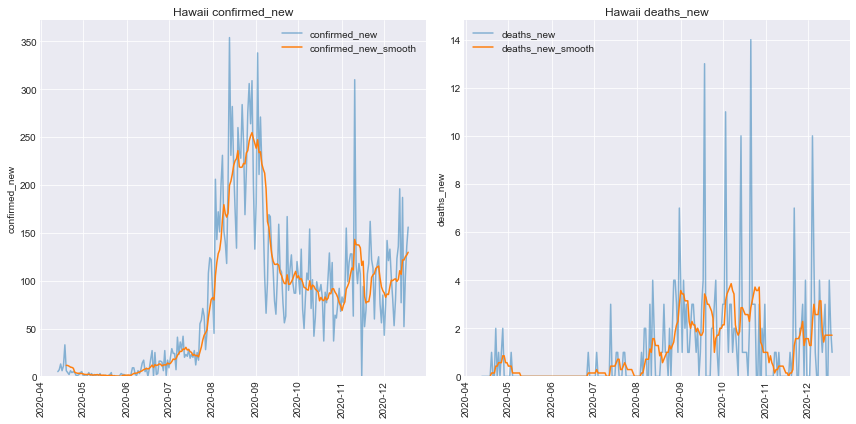

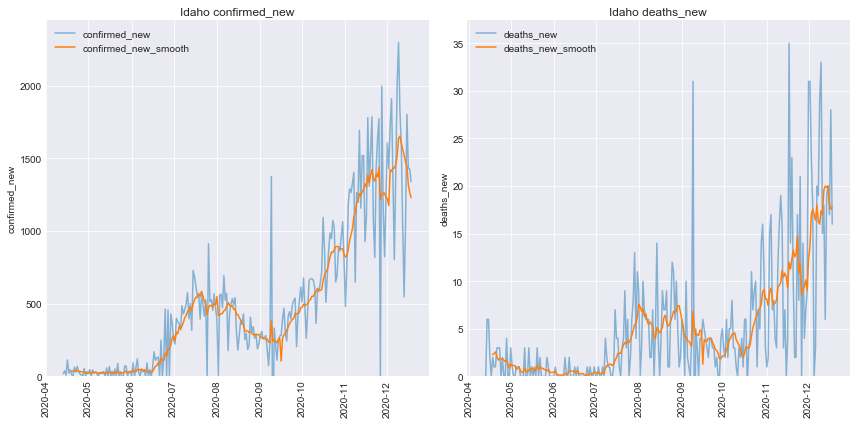

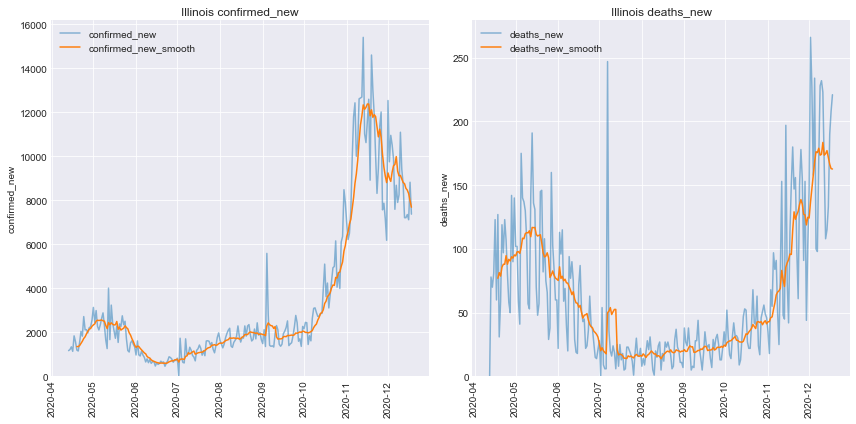

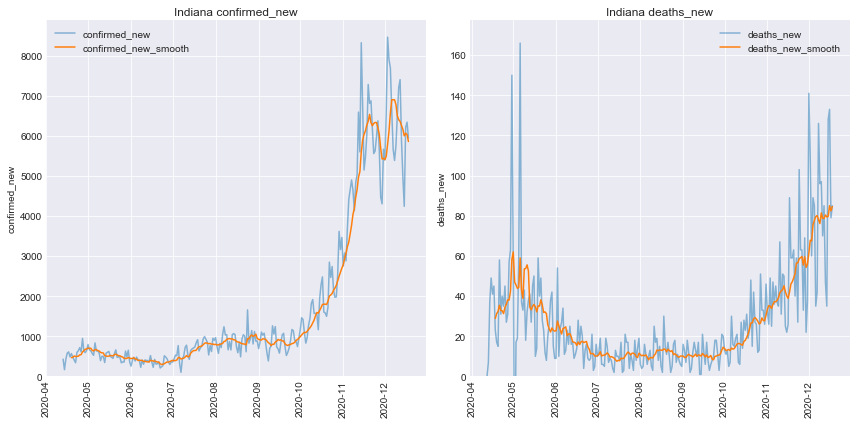

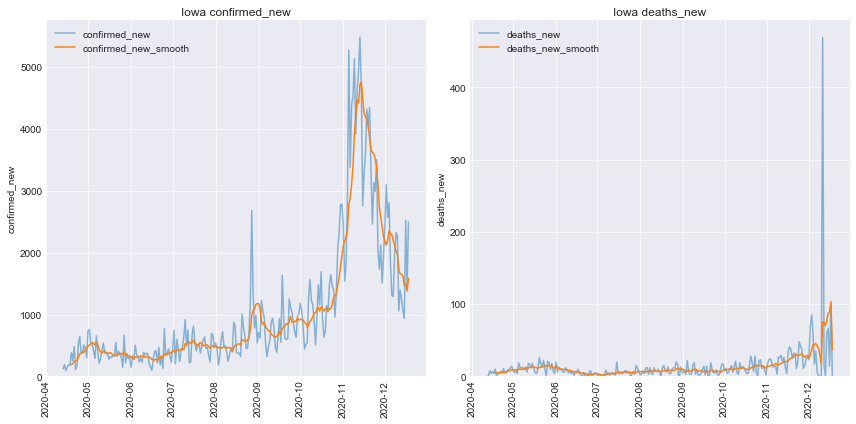

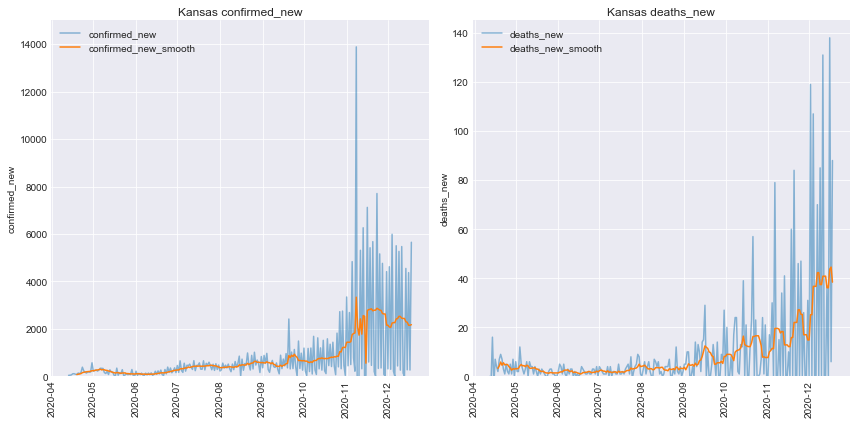

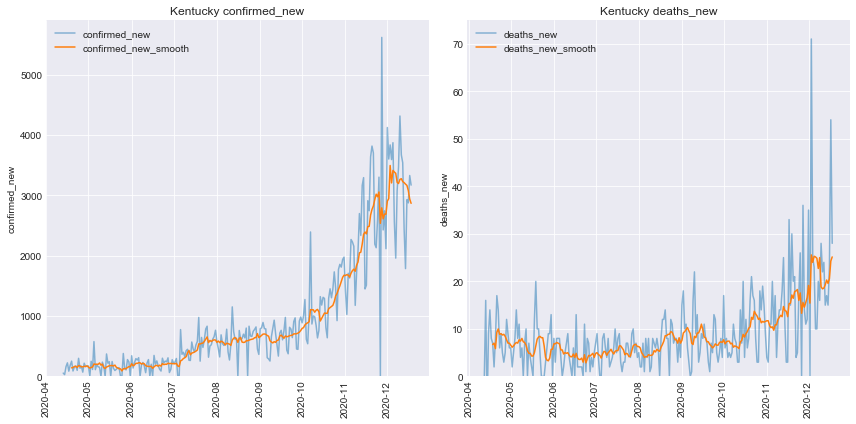

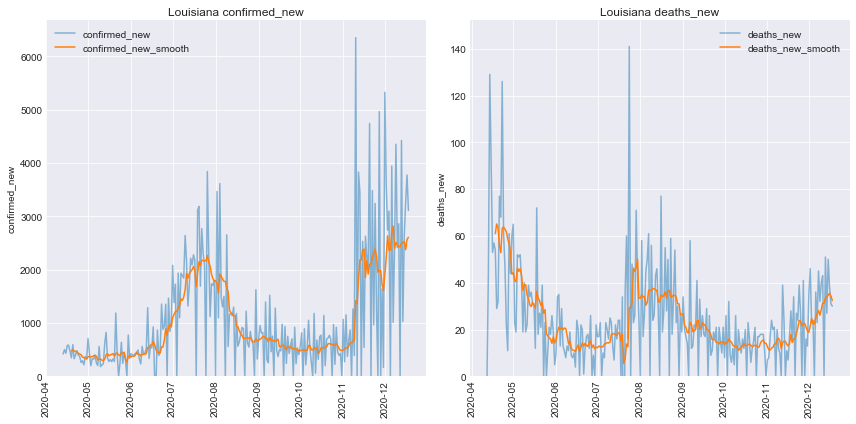

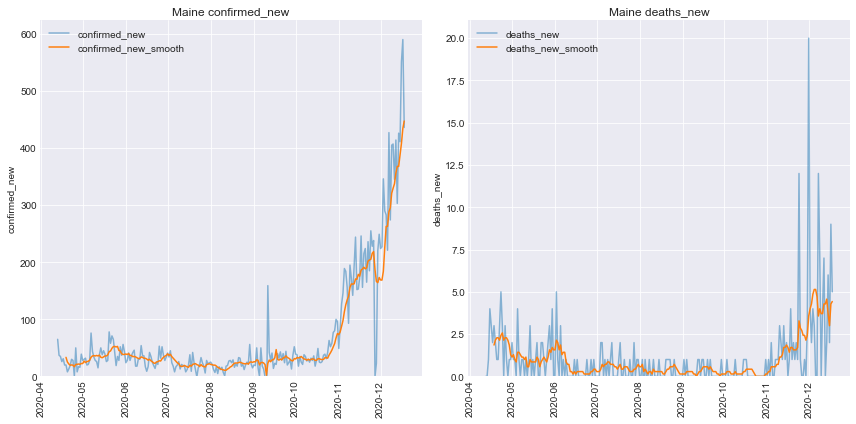

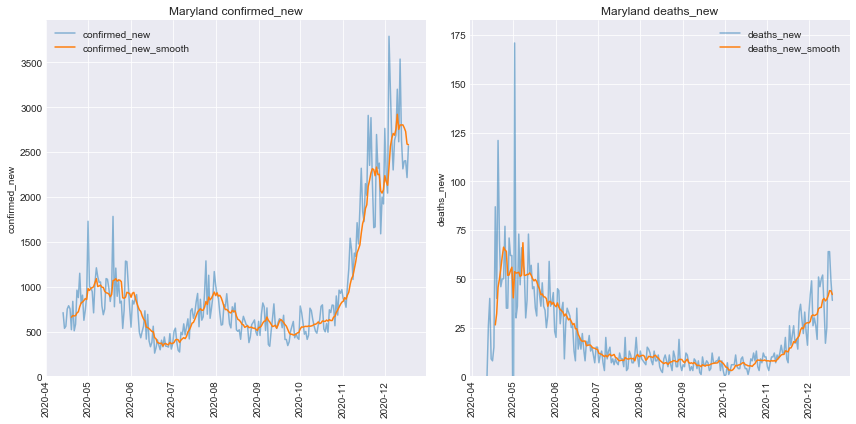

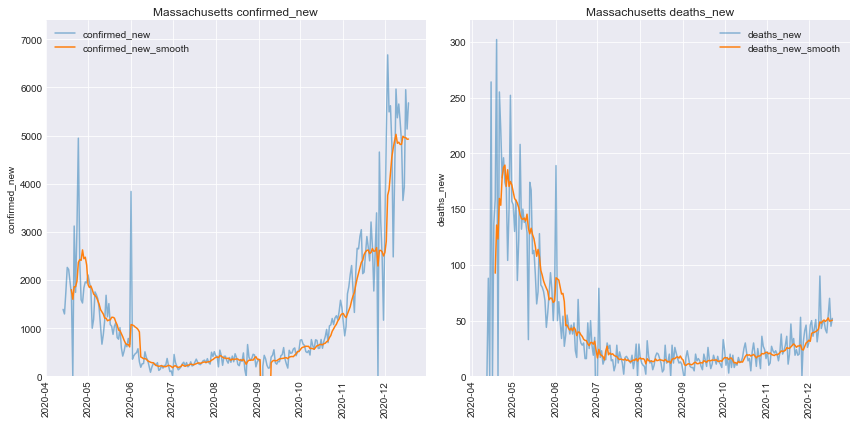

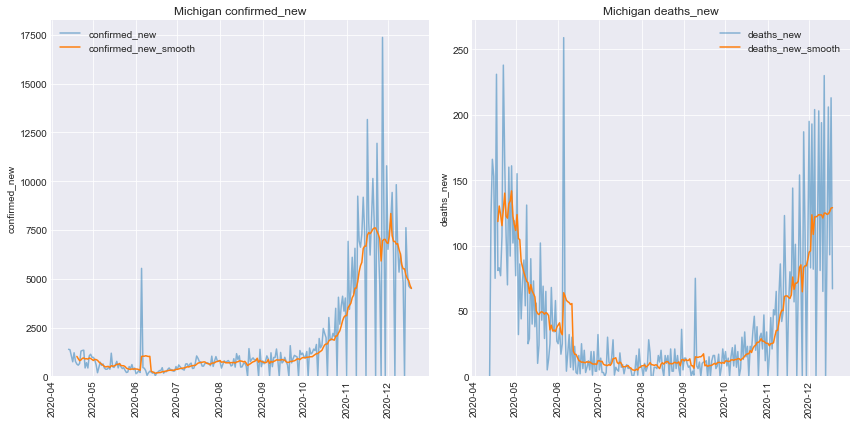

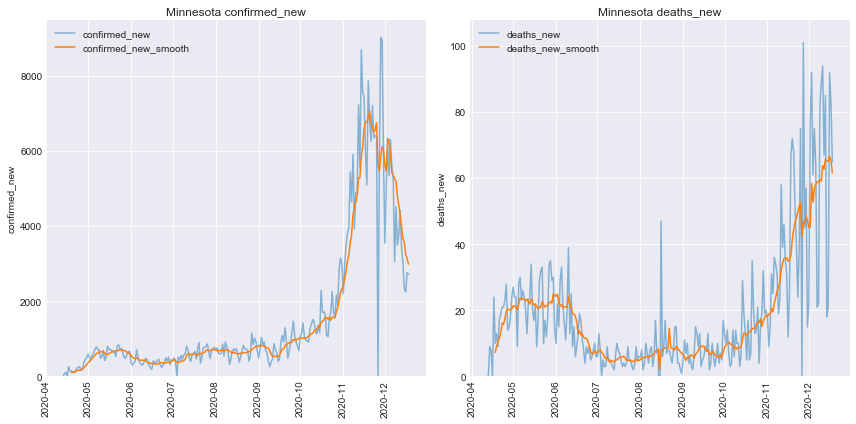

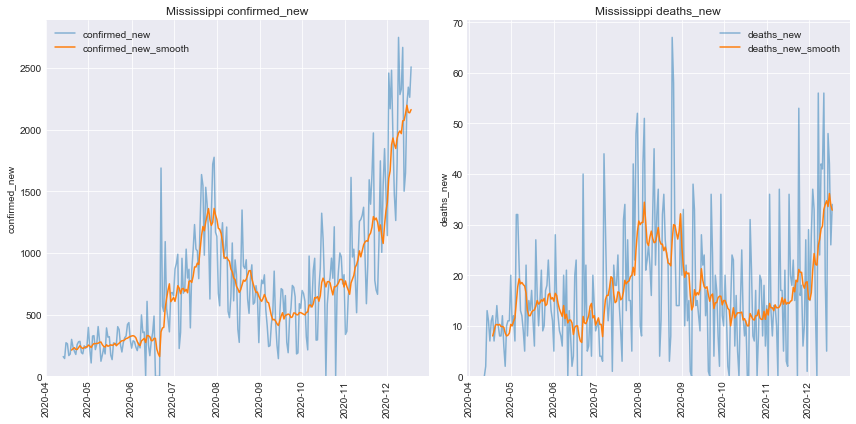

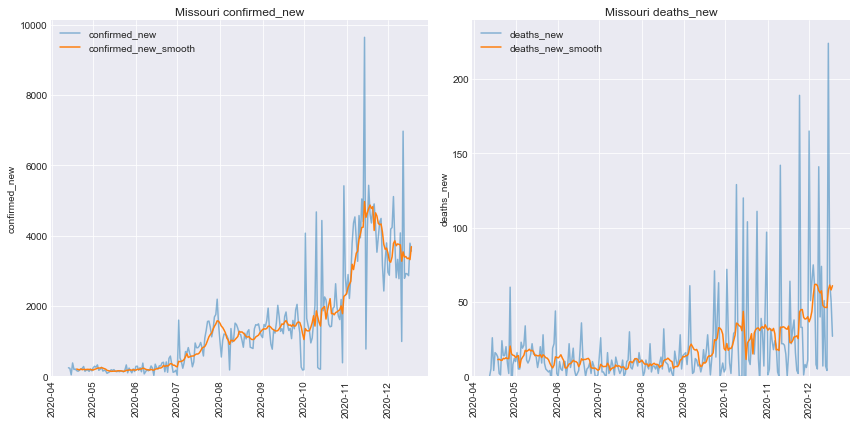

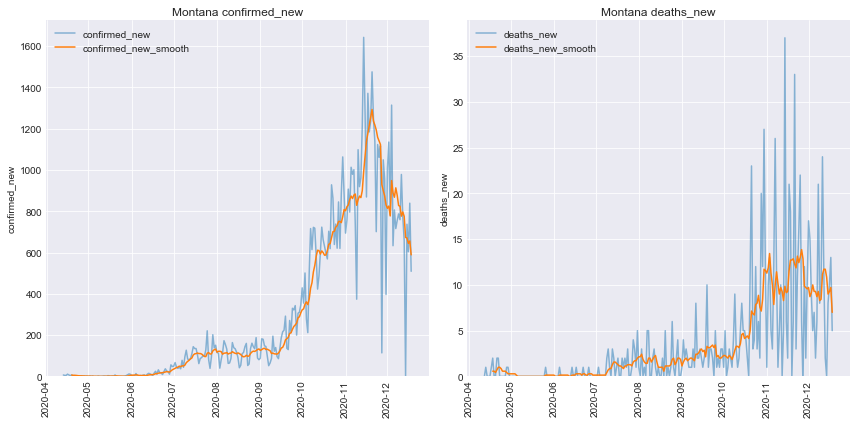

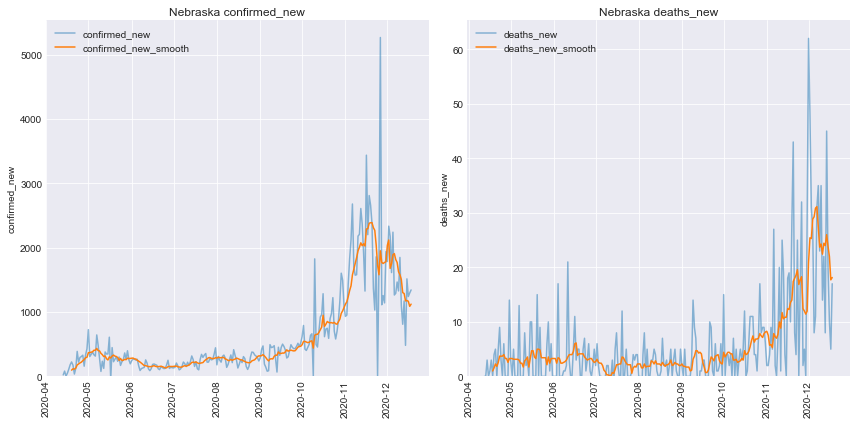

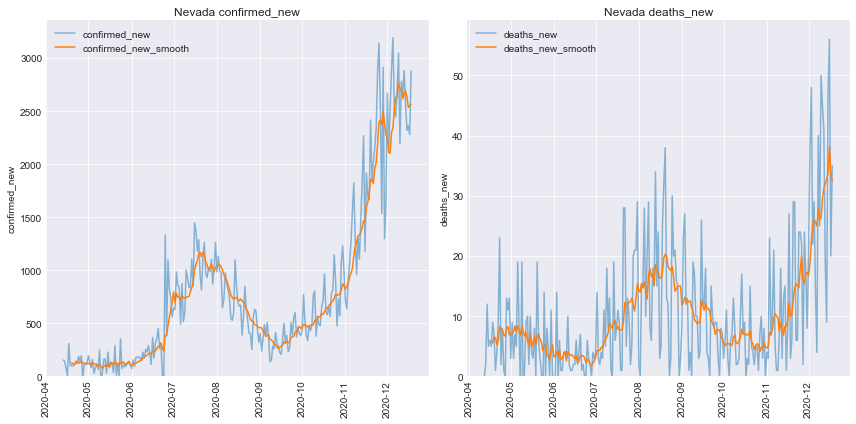

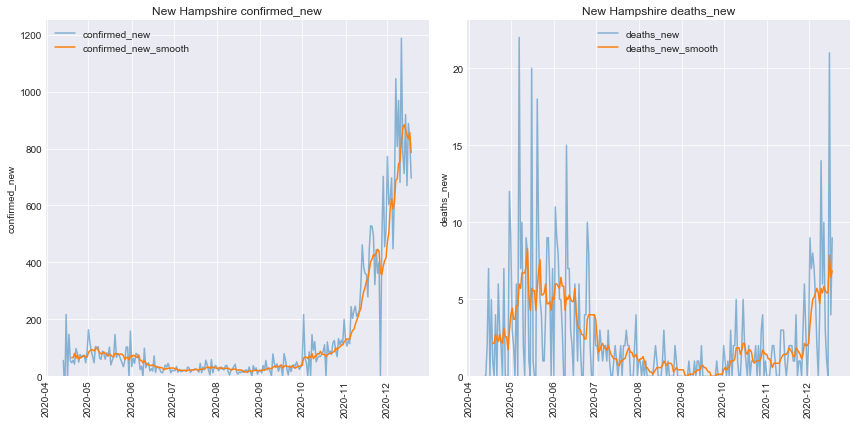

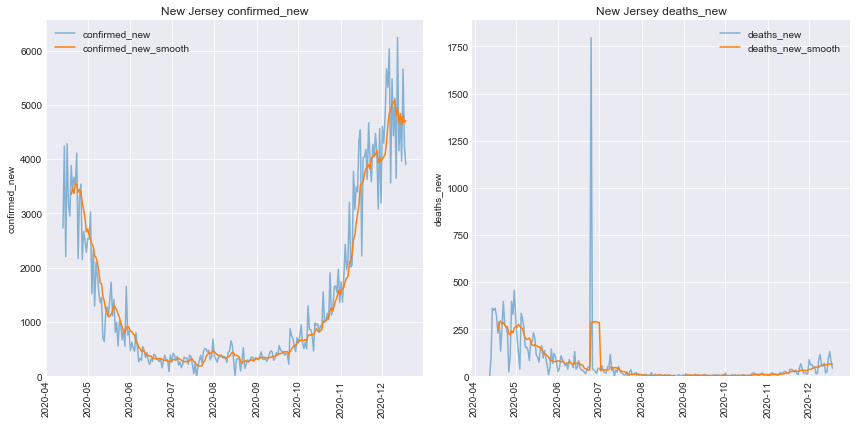

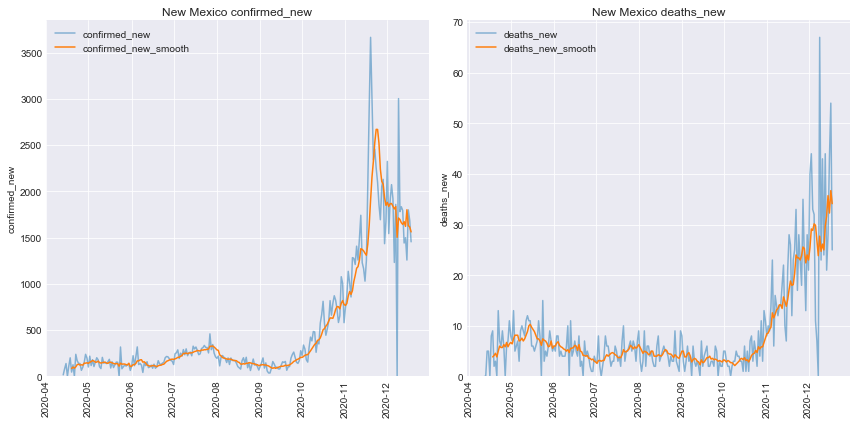

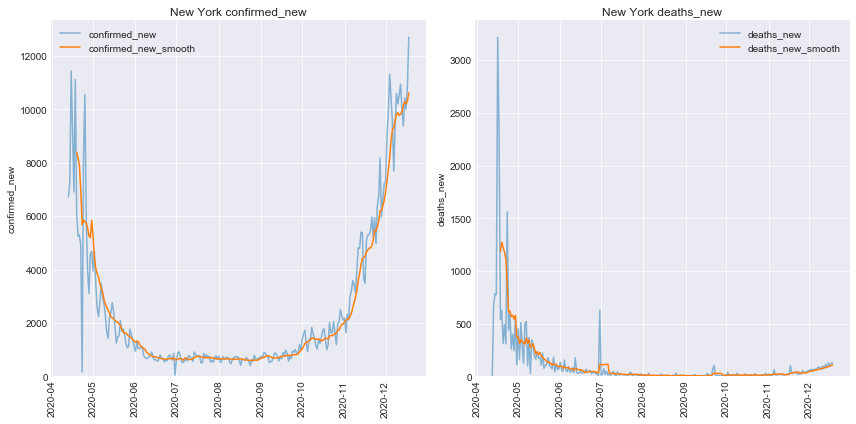

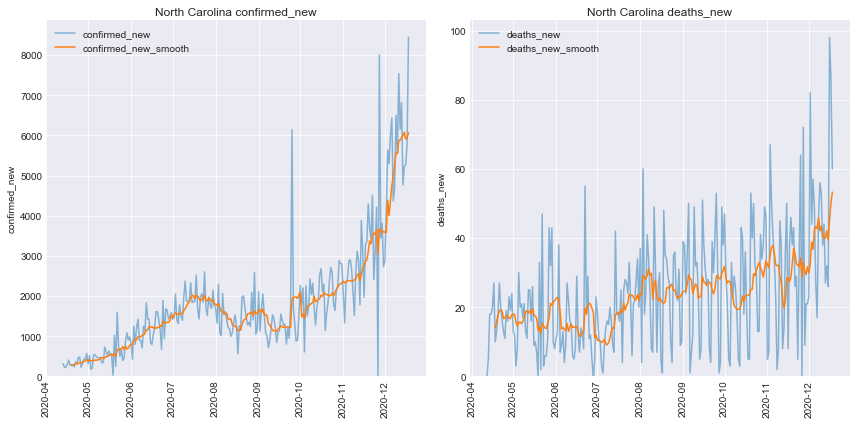

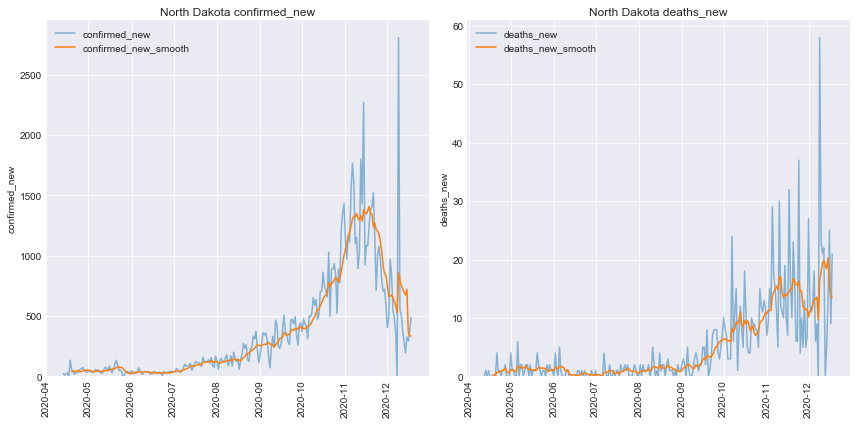

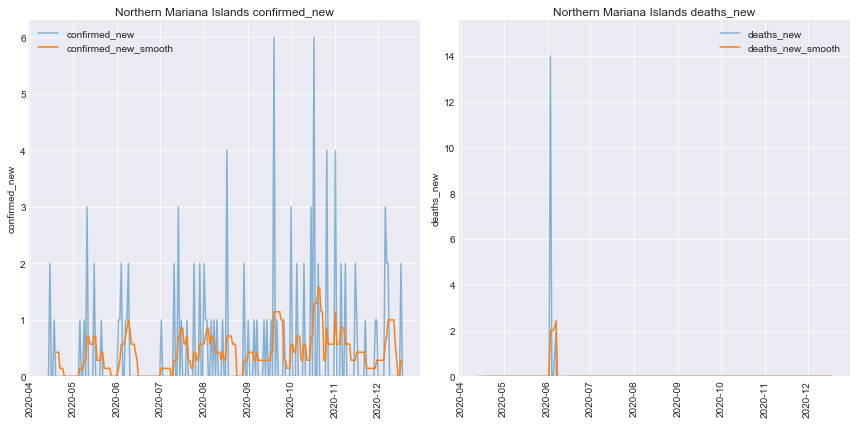

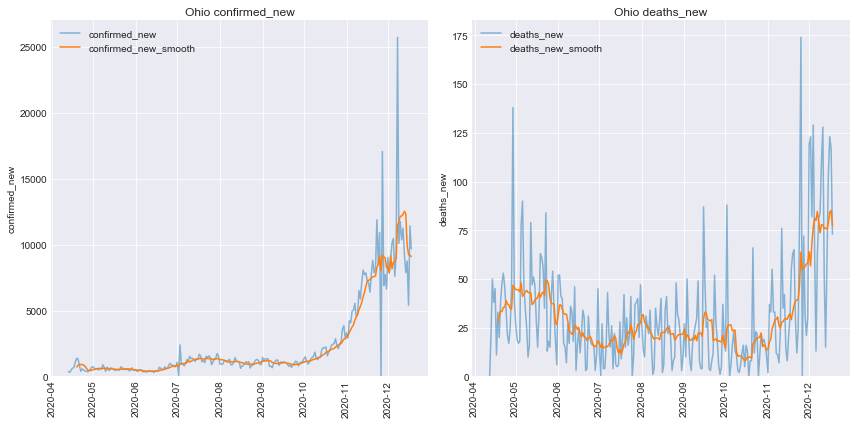

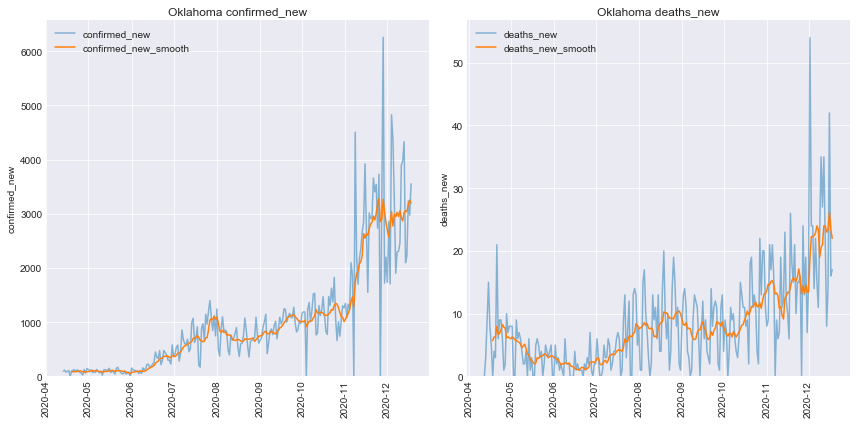

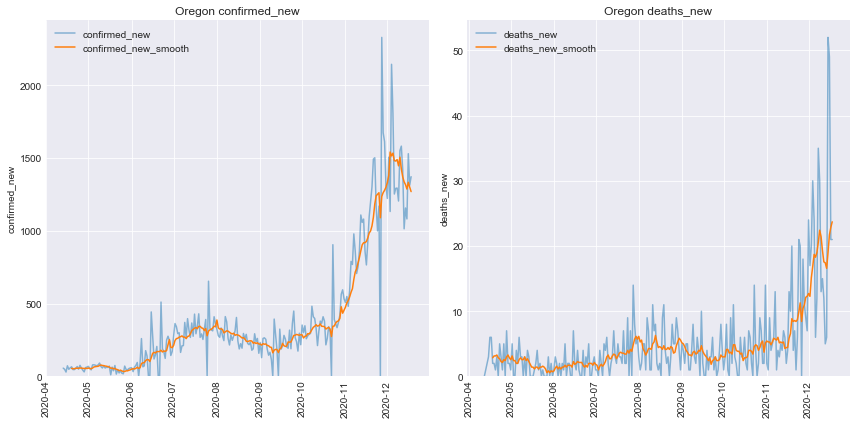

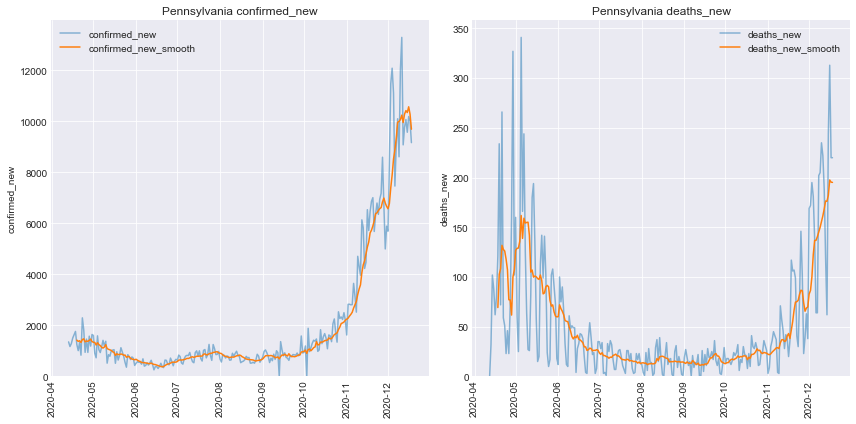

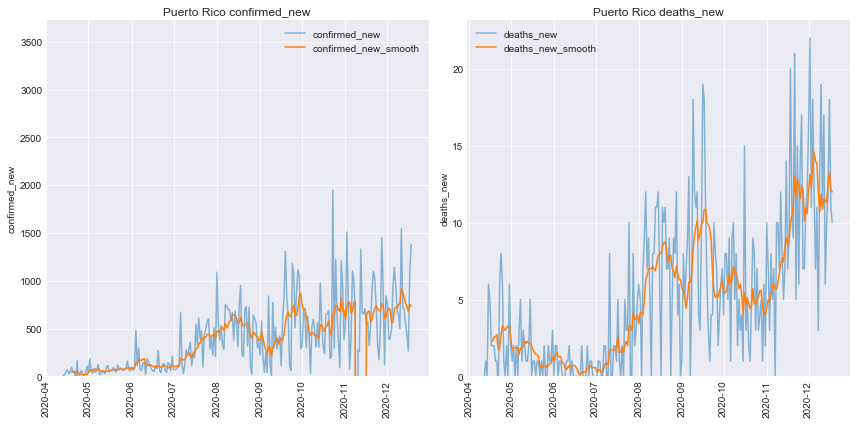

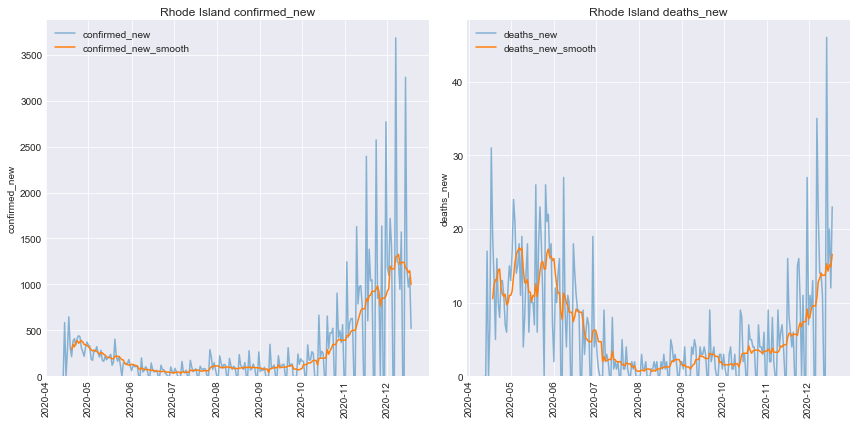

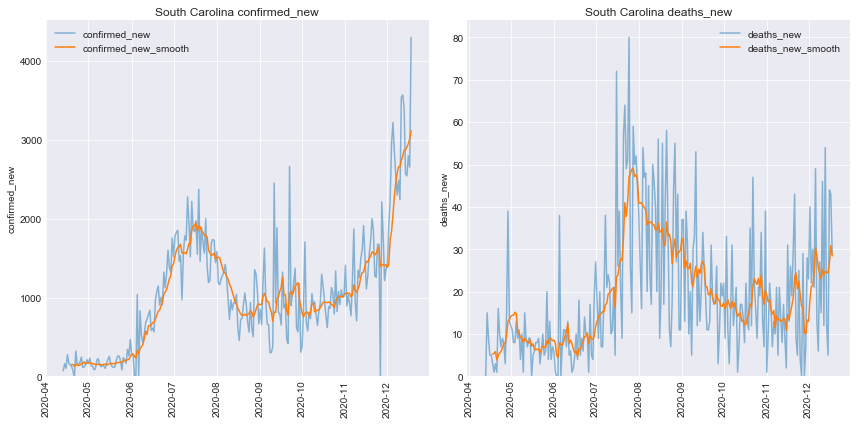

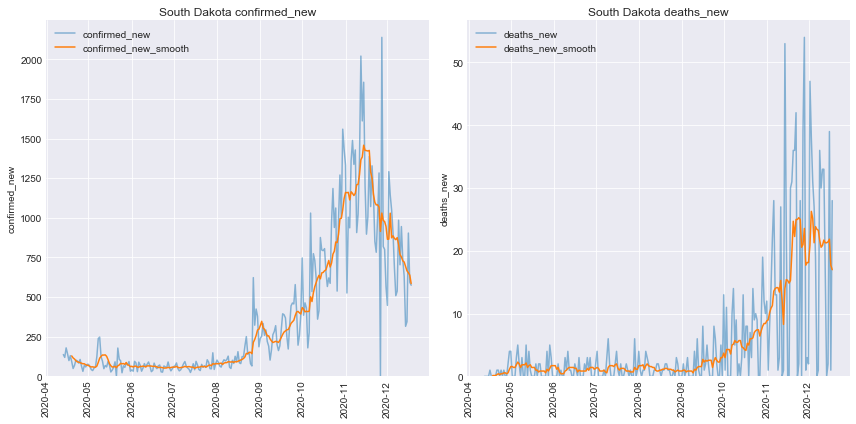

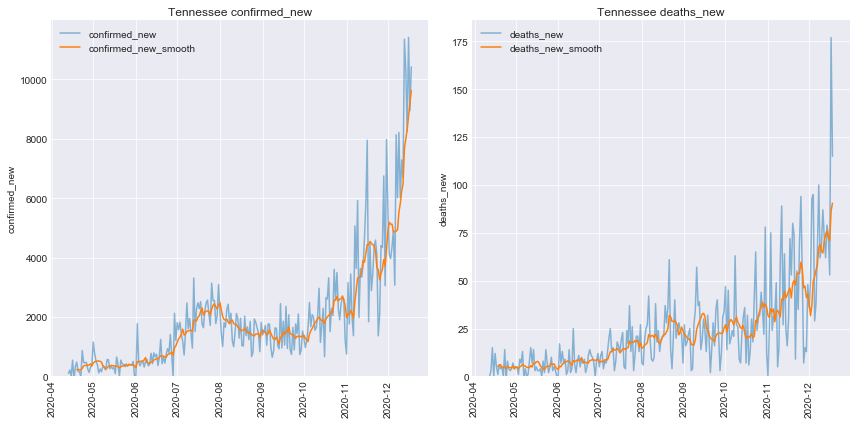

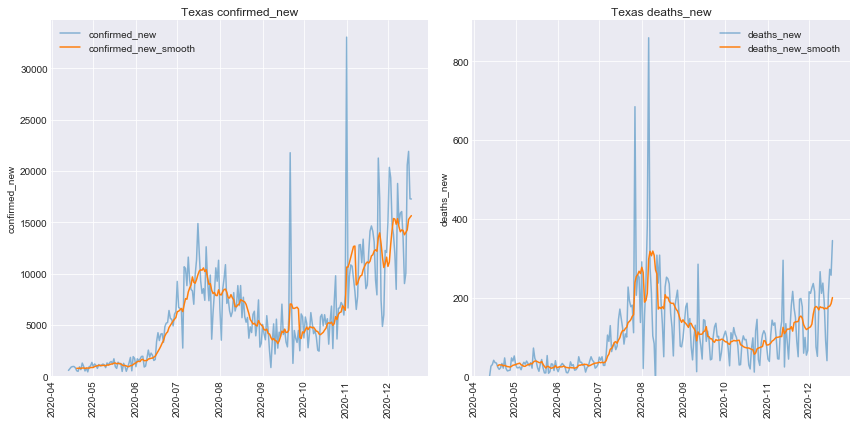

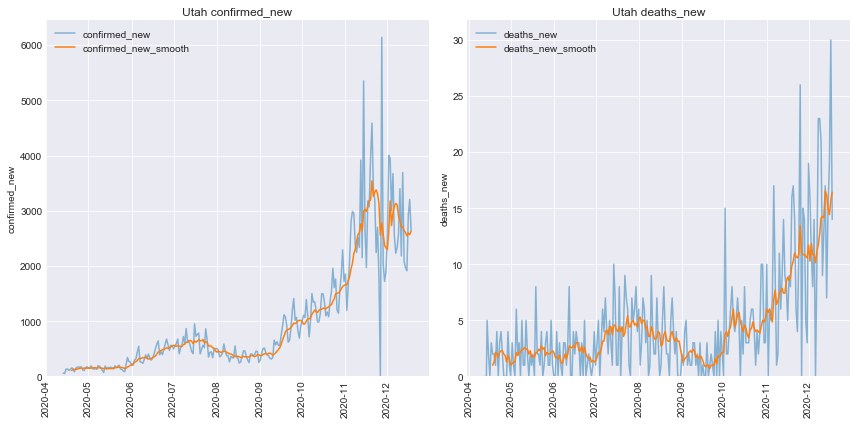

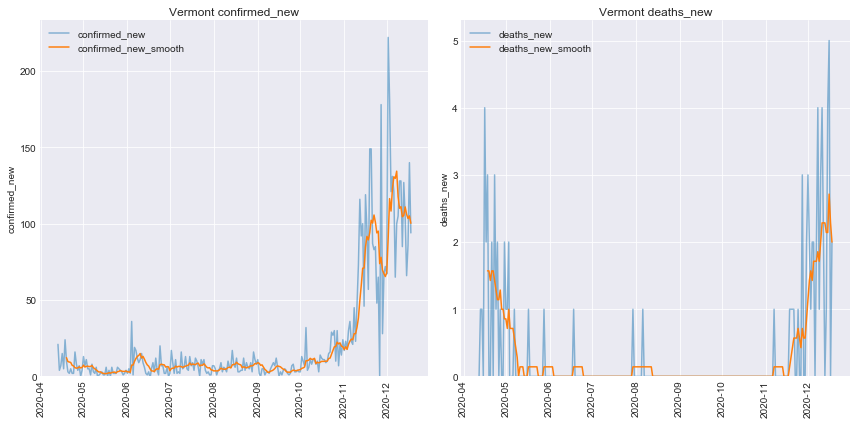

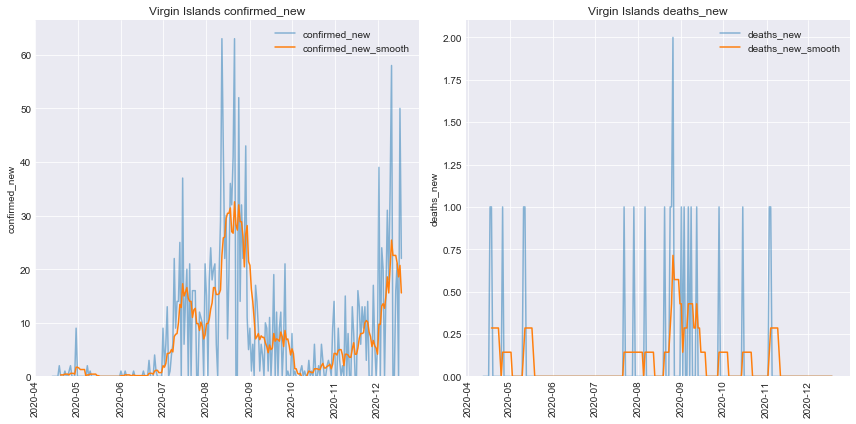

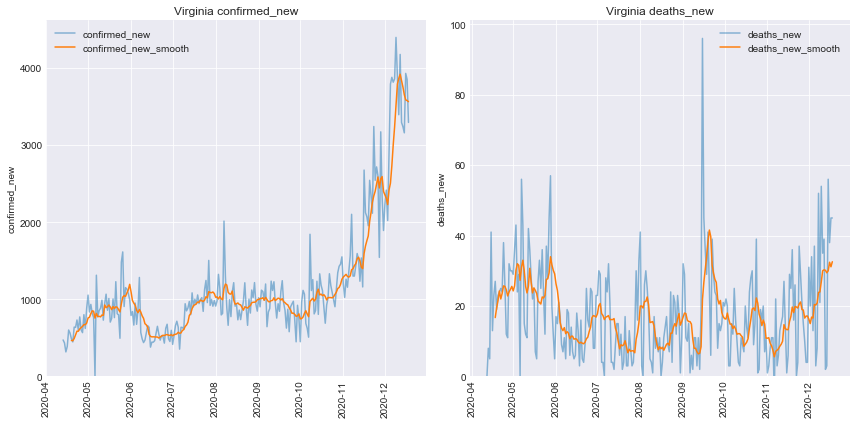

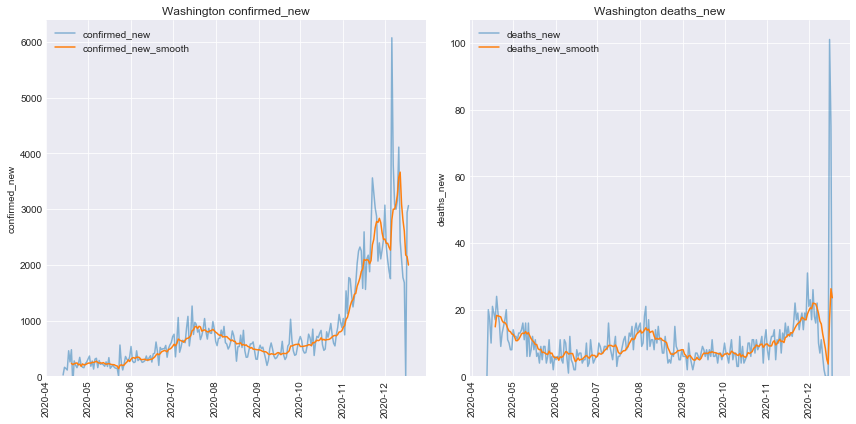

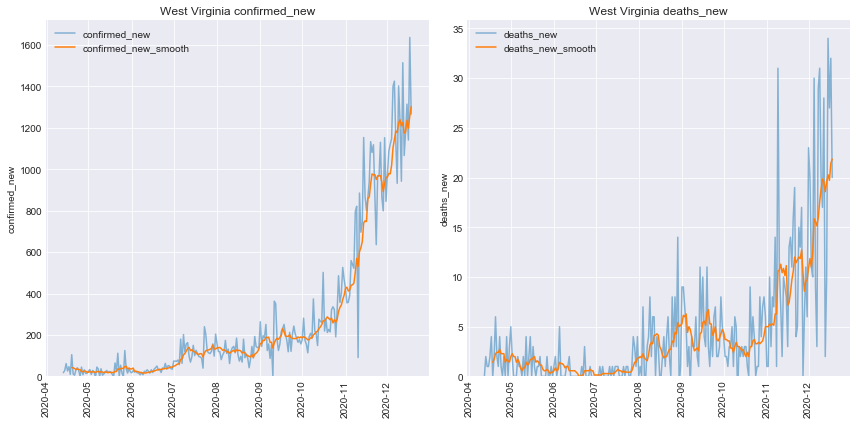

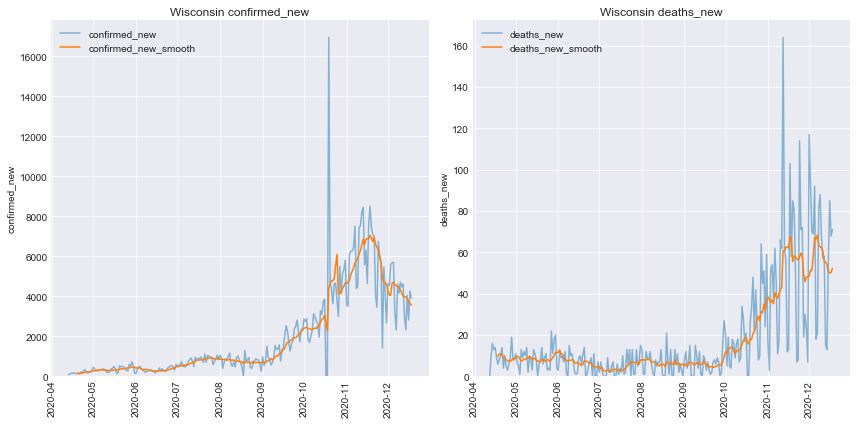

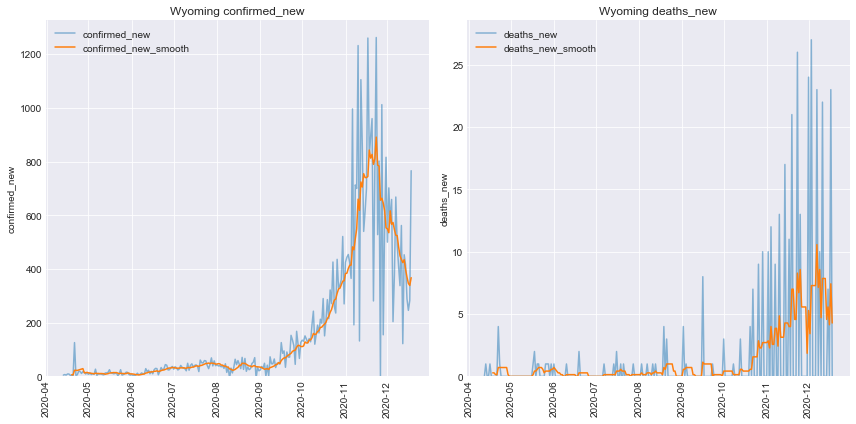

In [72]:


#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [73]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                 California              0.072609                 0.059944
1                   Arkansas              0.062336                 0.018759
2                    Arizona              0.059954                 0.034269
3              New Hampshire              0.059664                 0.041767
4               Pennsylvania              0.057921                 0.026154
5                       Iowa              0.057870                -0.027794
6                   New York              0.057223                 0.026909
7                   Colorado              0.052405                -0.014065
8                     Kansas              0.049167                -0.001350
9              West Virginia              0.046912                 0.017327
10               Mississippi              0.045501                 0.029243
11                 Tennessee              0.043654                 0.044151
12            South Carolina              0.043454                 0.047248
13                  Virginia              0.043412                 0.029203
14              Rhode Island              0.042178                 0.012931
15                New Jersey              0.041708                 0.010730
16                    Nevada              0.041530                 0.008663
17                  Delaware              0.033540                 0.030004
18             Massachusetts              0.032006                 0.037504
19                    Oregon              0.031634                -0.001848
20                 Louisiana              0.031538                 0.015335
21                     Idaho              0.031390                 0.005676
22      District of Columbia              0.031285                 0.018429
23                  Maryland              0.027032                 0.015821
24                    Alaska              0.026925                -0.009348
25                  Oklahoma              0.025994                 0.004584
26              North Dakota              0.025870                -0.029983
27               Connecticut              0.025150                 0.025067
28                      Utah              0.024801                 0.001238
29                     Texas              0.023478                 0.016334
30            North Carolina              0.022381                 0.032580
31                   Vermont              0.021531                 0.018719
32                   Alabama              0.021443                 0.030866
33                  Michigan              0.019410                -0.024176
34                 Minnesota              0.019407                -0.035904
35                  Missouri              0.019020                -0.002318
36                   Indiana              0.019000                 0.005043
37                   Florida              0.018870                 0.015516
38                      Ohio              0.016985                 0.013318
39                New Mexico              0.016982                -0.010450
40                  Illinois              0.016964                -0.006975
41                     Maine              0.016657                 0.056855
42                  Nebraska              0.015076                -0.029775
43                  Kentucky              0.011793                 0.004233
44                   Wyoming              0.010844                -0.030094
45                    Hawaii              0.007054                 0.019255
46                   Georgia              0.004630                 0.042429
47                 Wisconsin              0.003055                -0.011089
48               Puerto Rico              0.001633                 0.010218
49  Northern Mariana Islands              0.000000                 0.000000
50                      Guam              0.000000                -0.059652
51            Grand Princess              0.000000                 0.00

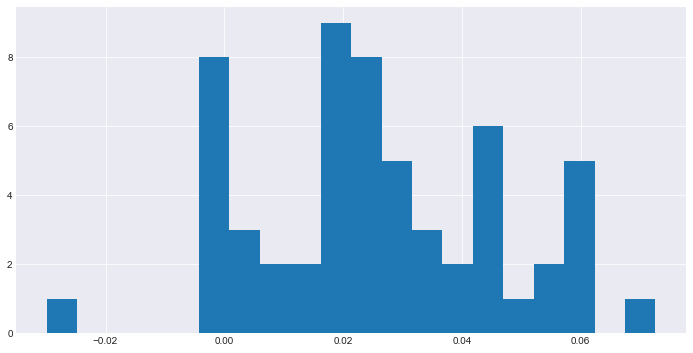

In [74]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

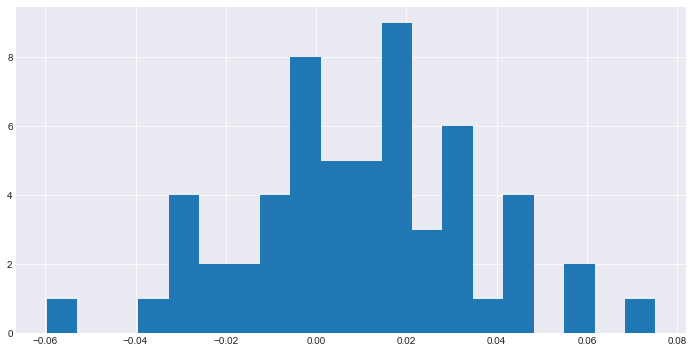

In [75]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [76]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0     California              0.072609                 0.059944
1       Arkansas              0.062336                 0.018759
2        Arizona              0.059954                 0.034269
3  New Hampshire              0.059664                 0.041767
4   Pennsylvania              0.057921                 0.026154
5           Iowa              0.057870                -0.027794
6       New York              0.057223                 0.026909
7       Colorado              0.052405                -0.014065
8         Kansas              0.049167                -0.001350
9  West Virginia              0.046912                 0.017327

### Which states are increasing in new deaths <u>least</u> quickly?

In [77]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48               Puerto Rico              0.001633                 0.010218
49  Northern Mariana Islands              0.000000                 0.000000
50                      Guam              0.000000                -0.059652
51            Grand Princess              0.000000                 0.000000
52            Virgin Islands              0.000000                 0.075138
53          Diamond Princess              0.000000                 0.000000
54            American Samoa              0.000000                 0.000000
55                   Montana             -0.000916                -0.016447
56              South Dakota             -0.003327                -0.023598
57                Washington             -0.029894                 0.000466

### Is there a day-of-the-week effect on new deaths?

Monday -> 0
Sunday -> 6

In [78]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [79]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [80]:
dfp_us_dow[dfp_us_dow.state=='Washington'].tail()

state       date country  confirmed  deaths  confirmed_lag1  \
1150  Washington 2020-12-14      US   212584.0  2941.0        210809.0   
1151  Washington 2020-12-15      US   214265.0  2941.0        212584.0   
1152  Washington 2020-12-16      US   214265.0  3042.0        214265.0   
1153  Washington 2020-12-17      US   217205.0  3117.0        214265.0   
1154  Washington 2020-12-18      US   220268.0  3104.0        217205.0   

      deaths_lag1  confirmed_new  deaths_new  mortality_rate  \
1150       2941.0         1775.0         0.0        0.013835   
1151       2941.0         1681.0         0.0        0.013726   
1152       2941.0            0.0       101.0        0.014197   
1153       3042.0         2940.0        75.0        0.014350   
1154       3117.0         3063.0       -13.0        0.014092   

      deaths_new_smooth  confirmed_new_smooth  confirmed_new_smooth_log  \
1150           5.142857           2805.285714                  3.447977   
1151           3.714286           2604.714286                  3.415760   
1152          17.142857           2176.714286                  3.337801   
1153          26.285714           2146.857143                  3.331803   
1154          23.571429           1997.142857                  3.300409   

      deaths_new_smooth_log      unixtime  recovered  active         slope  \
1150               0.711204  1.607904e+09        NaN     NaN -1.525553e-07   
1151               0.569875  1.607990e+09        NaN     NaN -1.525553e-07   
1152               1.234083  1.608077e+09        NaN     NaN -1.525553e-07   
1153               1.419720  1.608163e+09        NaN     NaN -1.525553e-07   
1154               1.372386  1.608250e+09        NaN     NaN -1.525553e-07   

      confirmed_new_smooth_pred  frac_increase_confirmed  \
1150                       2676                 0.000466   
1151                       2677                 0.000466   
1152                       2678                 0.000466   
1153                       2679                 0.000466   
1154                       2681                 0.000466   

      deaths_new_smooth_pred  frac_increase_deaths  dow  death_delta  \
1150                      12             -0.029894    0        -12.0   
1151                      12             -0.029894    1        -12.0   
1152                      12             -0.029894    2         89.0   
1153                      11             -0.029894    3         64.0   
1154                      11             -0.029894    4        -24.0   

      death_rel_delta  confirmed_delta  confirmed_rel_delta  
1150        -1.000000           -901.0            -0.336697  
1151        -1.000000           -996.0            -0.372058  
1152         7.416667          -2678.0            -1.000000  
1153         5.818182            261.0             0.097424  
1154        -2.181818            382.0             0.142484

In [81]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0     2.000000         0.002193   17.666667   
379  Washington    1    -5.000000        -0.409357   10.333333   
380  Washington    2    28.666667         2.387037   43.666667   
381  Washington    3    20.000000         1.849447   34.333333   
382  Washington    4    -7.666667        -0.741278    6.333333   
383  Washington    5    -4.000000        -0.294189   13.000000   
384  Washington    6    -5.333333        -0.383333   11.000000   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378               15.666667        10.333333             0.004170  
379               15.333333       -56.000000            -0.020417  
380               15.000000      -895.666667            -0.334584  
381               14.333333        54.000000             0.019876  
382               14.000000       348.000000             0.129752  
383               17.000000      -568.333333            -0.213442  
384               16.333333       811.666667             0.304504

In [82]:
# alpha_soft = 0.15
# alpha_hard = 0.8
# for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
#     dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
#     dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
#     p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
#     color = p[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
#     q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
#     color = q[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
#     plt.legend(loc='best')
#     plt.axhline(0, color='k')
#     plt.title(f'state={state}')

#     #plt.ylim([-0.5,0.5])
#     #plt.ylim([-2,2])
#     plt.show()

# Cases per capita by state

In [83]:
dfp_state_census = pd.read_csv('supporting_data/nst-est2019-alldata.csv')

In [84]:
dfp_us_g.shape

(14576, 12)

In [85]:
cols_state_pop = ['NAME', 'POPESTIMATE2019'] #'STATE',
dfp_state_census_clean = dfp_state_census[cols_state_pop][dfp_state_census['STATE'] > 0]
#dfp_state_census_clean = dfp_state_census_clean.rename(columns={'STATE': 'STATE_NUMBER'})
dfp_state_census_clean.columns = [x.lower() for x in dfp_state_census_clean.columns]
pop_col = 'population'
cols_state_translate = {'name': 'state', 'popestimate2019': pop_col}
dfp_state_census_clean = dfp_state_census_clean.rename(columns=cols_state_translate)
dfp_us_g1 = dfp_us_g.copy()
dfp_us_g1 = dfp_us_g1.merge(dfp_state_census_clean, on='state', how='inner')

# add normalized columns
norm_factor = 1E6
dfp_us_g1['deaths_new_per_1m'] = dfp_us_g1['deaths_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m'] = dfp_us_g1['confirmed_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['deaths_new_per_1m_smooth'] = dfp_us_g1['deaths_new_smooth'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m_smooth'] = dfp_us_g1['confirmed_new_smooth'] / dfp_us_g1[pop_col] * norm_factor

In [86]:
dfp_us_g1.shape

(13052, 17)

<a id='us_state_maps'></a>
# Plot maps

In [87]:
dfp_us_g1_newest = dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()].copy()
#print(f'There are {len(dfp_us_g1_newest.columns)}')
cols1 = set(dfp_us_g1_newest.columns)
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_state_codes, left_on='state', right_on='state_name', how='left')
#print(f'After merge there are {len(dfp_us_g1_newest.columns)}')
cols2 = set(dfp_us_g1_newest.columns)

In [88]:
dfp_us_g1_newest = dfp_us_g1_newest.sort_values(by='confirmed_new_per_1m_smooth', ascending=0)
dfp_us_g1_newest.head(10)

date country         state  confirmed  deaths  confirmed_lag1  \
15 2020-12-18      US     Tennessee     503651    5960        493230.0   
31 2020-12-18      US    California    1802195   22370       1753974.0   
29 2020-12-18      US       Arizona     442671    7819        435036.0   
24 2020-12-18      US  Rhode Island      77812    1625         77290.0   
42 2020-12-18      US       Indiana     453139    7265        447190.0   
1  2020-12-18      US        Nevada     199257    2706        196379.0   
17 2020-12-18      US          Utah     246562    1140        243918.0   
9  2020-12-18      US      Oklahoma     251760    2161        248204.0   
0  2020-12-18      US       Alabama     315683    4296        310335.0   
8  2020-12-18      US          Ohio     605862    7967        596178.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
15       5845.0        10421.0       115.0        0.011834          90.428571   
31      22094.0        48221.0       276.0        0.012413         226.142857   
29       7677.0         7635.0       142.0        0.017663          82.000000   
24       1602.0          522.0        23.0        0.020884          16.571429   
42       7180.0         5949.0        85.0        0.016033          84.571429   
1        2671.0         2878.0        35.0        0.013580          32.428571   
17       1126.0         2644.0        14.0        0.004624          16.428571   
9        2144.0         3556.0        17.0        0.008584          22.000000   
0        4254.0         5348.0        42.0        0.013609          30.000000   
8        7894.0         9684.0        73.0        0.013150          77.285714   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
15           9627.000000     6829174          16.839518           1525.953212   
31          40854.285714    39512223           6.985180           1220.407164   
29           6879.857143     7278717          19.508933           1048.948599   
24            999.142857     1059361          21.711201            492.749875   
42           5857.714286     6732219          12.625852            883.661093   
1            2563.857143     3080156          11.363061            934.368259   
17           2633.285714     3205958           4.366869            824.714485   
9            3201.000000     3956971           4.296215            898.667188   
0            3844.000000     4903185           8.565861           1090.719604   
8            9093.285714    11689100           6.245134            828.464125   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth    state_name  \
15                 13.241509                  1409.687321     Tennessee   
31                  5.723365                  1033.965761    California   
29                 11.265722                   945.201901       Arizona   
24                 15.642853                   943.156164  Rhode Island   
42                 12.562192                   870.101565       Indiana   
1                  10.528224                   832.378991        Nevada   
17                  5.124388                   821.372493          Utah   
9                   5.559808                   808.952100      Oklahoma   
0                   6.118472                   783.980209       Alabama   
8                   6.611776                   777.928644          Ohio   

   two_letter_code  
15              TN  
31              CA  
29              AZ  
24              RI  
42              IN  
1               NV  
17              UT  
9               OK  
0               AL  
8               OH

In [89]:
def plot_us_map(df, plot_col, color='Reds', col_state_abbrev='two_letter_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_state_abbrev], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [90]:
dfp_us_g1_newest.head()

date country         state  confirmed  deaths  confirmed_lag1  \
15 2020-12-18      US     Tennessee     503651    5960        493230.0   
31 2020-12-18      US    California    1802195   22370       1753974.0   
29 2020-12-18      US       Arizona     442671    7819        435036.0   
24 2020-12-18      US  Rhode Island      77812    1625         77290.0   
42 2020-12-18      US       Indiana     453139    7265        447190.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
15       5845.0        10421.0       115.0        0.011834          90.428571   
31      22094.0        48221.0       276.0        0.012413         226.142857   
29       7677.0         7635.0       142.0        0.017663          82.000000   
24       1602.0          522.0        23.0        0.020884          16.571429   
42       7180.0         5949.0        85.0        0.016033          84.571429   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
15           9627.000000     6829174          16.839518           1525.953212   
31          40854.285714    39512223           6.985180           1220.407164   
29           6879.857143     7278717          19.508933           1048.948599   
24            999.142857     1059361          21.711201            492.749875   
42           5857.714286     6732219          12.625852            883.661093   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth    state_name  \
15                 13.241509                  1409.687321     Tennessee   
31                  5.723365                  1033.965761    California   
29                 11.265722                   945.201901       Arizona   
24                 15.642853                   943.156164  Rhode Island   
42                 12.562192                   870.101565       Indiana   

   two_letter_code  
15              TN  
31              CA  
29              AZ  
24              RI  
42              IN

In [91]:
dfp_us_g1_newest[dfp_us_g1_newest.state == 'Washington']

date country       state  confirmed  deaths  confirmed_lag1  \
20 2020-12-18      US  Washington     220268    3104        217205.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
20       3117.0         3063.0       -13.0        0.014092          23.571429   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
20           1997.142857     7614893          -1.707181            402.238088   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth  state_name  \
20                  3.095438                   262.268013  Washington   

   two_letter_code  
20              WA

In [92]:
plot_us_map(dfp_us_g1_newest, plot_col='confirmed_new_per_1m_smooth')

In [93]:
plot_us_map(dfp_us_g1_newest, plot_col='deaths_new_per_1m_smooth')

In [94]:
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_us_frac_new_increase, on='state', how='left')

In [95]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_confirmed')

In [96]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_deaths')

# County level

In [97]:
os.getcwd()

'/Users/tboats/Dropbox (Facebook)/personal/data_sciencey/covid_19/analysis'

In [98]:
dfp_king_raw = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-22-2020.csv')

In [99]:
dfp_king_raw.head()

FIPS         Admin2 Province_State Country_Region    Last_Update  \
0  36061.0  New York City       New York             US  3/22/20 23:45   
1  36059.0         Nassau       New York             US  3/22/20 23:45   
2  36119.0    Westchester       New York             US  3/22/20 23:45   
3  36103.0        Suffolk       New York             US  3/22/20 23:45   
4  36087.0       Rockland       New York             US  3/22/20 23:45   

         Lat      Long_  Confirmed  Deaths  Recovered  Active  \
0  40.767273 -73.971526       9654      63          0       0   
1  40.740665 -73.589419       1900       4          0       0   
2  41.162784 -73.757417       1873       0          0       0   
3  40.883201 -72.801217       1034       9          0       0   
4  41.150279 -74.025605        455       1          0       0   

                  Combined_Key  
0  New York City, New York, US  
1         Nassau, New York, US  
2    Westchester, New York, US  
3        Suffolk, New York, US  
4       Rockland, New York, US

In [100]:
dfp_king_raw.shape

(3419, 12)

In [101]:
dfp_king_raw[(dfp_king_raw.Country_Region == 'US') & (dfp_king_raw.Admin2 == 'King')]

FIPS Admin2 Province_State Country_Region    Last_Update        Lat  \
45    53033.0   King     Washington             US  3/22/20 23:45  47.491379   
2843  48269.0   King          Texas             US  3/22/20 23:45  33.616438   

           Long_  Confirmed  Deaths  Recovered  Active          Combined_Key  
45   -121.834613       1040      75          0       0  King, Washington, US  
2843 -100.255806          0       0          0       0       King, Texas, US

In [102]:
dfp_king_raw.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key'],
      dtype='object')

In [103]:
dfp_king_raw.Country_Region.value_counts()

US              3178
China             33
Canada            14
Australia         10
France            10
                ... 
Lebanon            1
Algeria            1
Cyprus             1
Saudi Arabia       1
Hungary            1
Name: Country_Region, Length: 168, dtype: int64

In [104]:
datetime.datetime.strptime('01-27-2020', '%m-%d-%Y')

datetime.datetime(2020, 1, 27, 0, 0)

In [105]:
len(data_paths)

251

In [106]:
def clean_county(
    state_base_dir='../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/',
    grouping_cols=['country', 'state', 'county']
):
    # load and clean data from CSSEGIS
    
    data_paths_raw = os.listdir(state_base_dir)
    data_paths = sorted([path for path in data_paths_raw if path.endswith('csv')])
    list_dfp_states = []
    cols_of_interest = ['country', 'state_raw', 'county', 'date', 'confirmed', 'deaths', 'recovered']
    for idx, path in enumerate(data_paths):
        if (idx + 1) % 10 == 0:
            print(f'{idx + 1} of {len(data_paths)} ({100 * (idx + 1) / len(data_paths)}%)')
        
        # check if date is 2020-03-22 or later (schema change)
        file_date = path.split('.')[0]
        file_dt = datetime.datetime.strptime(file_date, '%m-%d-%Y')
        if file_dt < datetime.datetime(2020,3,22):
            continue
        
        full_path = os.path.join(state_base_dir, path)

        # read state data
        dfp_temp = pd.read_csv(full_path)
        cols = list(dfp_temp.columns)
        #print(dfp_temp.columns)

        # clean column names
        cols_translate = {'Country/Region': 'country',
                          'Province/State': 'state_raw',
                          'Confirmed': 'confirmed',
                          'Deaths': 'deaths',
                          'Recovered': 'recovered',
                          'Country_Region': 'country',
                          'Province_State': 'state_raw',
                          'Admin2': 'county',
                          'Last_Update': 'Last Update',
                          'People_Hospitalized': 'people_hospitalized'
                         }
        dfp_temp = dfp_temp.rename(columns=cols_translate)
        
        #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())

        dfp_temp['date'] = file_dt  #datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
        #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
        dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
        list_dfp_states.append(dfp_temp[cols_of_interest])
    dfp_us_raw = pd.concat(list_dfp_states)
    dfp_us_raw['state_clean_1'] = dfp_us_raw['state_raw'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

    # load codes to convert two-letter codes to state names
    dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
    dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
    dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

    # get the most appropriate state name
    dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
    dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)
    dfp_us = dfp_us.rename(columns={'state_clean': 'state'})

    # aggregate infections by state
    dfp_us_g = (dfp_us.groupby(['date'] + grouping_cols, as_index=False).
                agg({
                    'confirmed': np.sum,
                    'deaths': np.sum,
                    #'recovered': np.sum,
                   })
               )
    dfp_us_g = dfp_us_g.sort_values(by='date')
    #dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
    #dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
    dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(grouping_cols)['confirmed'].shift(1)
    dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(grouping_cols)['deaths'].shift(1)
    dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
    dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']
    
    # smoothed trend
    dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
    dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
    return dfp_us_g

In [107]:
dfp_county_g = clean_county()

10 of 332 (3.0120481927710845%)
20 of 332 (6.024096385542169%)
30 of 332 (9.036144578313253%)
40 of 332 (12.048192771084338%)
50 of 332 (15.060240963855422%)
60 of 332 (18.072289156626507%)
70 of 332 (21.08433734939759%)
80 of 332 (24.096385542168676%)
90 of 332 (27.10843373493976%)
100 of 332 (30.120481927710845%)
110 of 332 (33.13253012048193%)
120 of 332 (36.144578313253014%)
130 of 332 (39.1566265060241%)
140 of 332 (42.16867469879518%)
150 of 332 (45.18072289156626%)
160 of 332 (48.19277108433735%)
170 of 332 (51.204819277108435%)
180 of 332 (54.21686746987952%)
190 of 332 (57.2289156626506%)
200 of 332 (60.24096385542169%)
210 of 332 (63.25301204819277%)
220 of 332 (66.26506024096386%)
230 of 332 (69.27710843373494%)
240 of 332 (72.28915662650603%)
250 of 332 (75.3012048192771%)
260 of 332 (78.3132530120482%)
270 of 332 (81.32530120481928%)
280 of 332 (84.33734939759036%)
290 of 332 (87.34939759036145%)
300 of 332 (90.36144578313252%)
310 of 332 (93.37349397590361%)
320 of 332 (9

In [108]:
def plot_county(state, county):
    dfp_county_oi = dfp_county_g[(dfp_county_g.state == state) & (dfp_county_g.county == county)]
    plot_smoothed_trend(dfp_county_oi, [county], cols_plot=['confirmed_new', 'deaths_new'], state_col='county')
    return dfp_county_oi

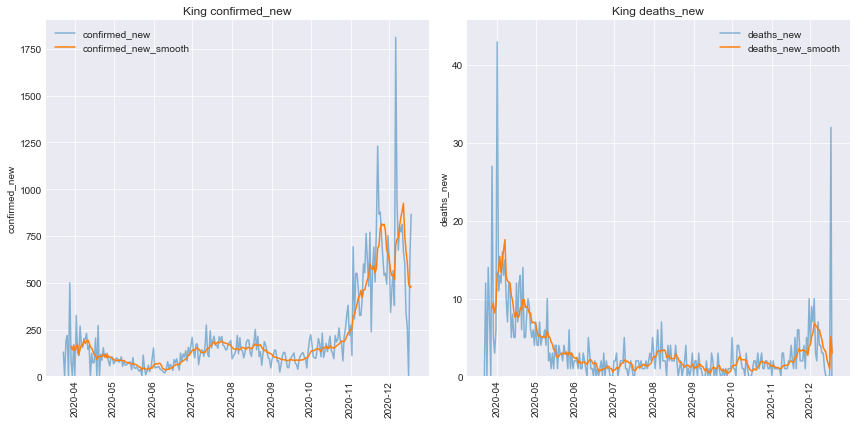

In [109]:
dfp_king = plot_county('Washington', 'King')

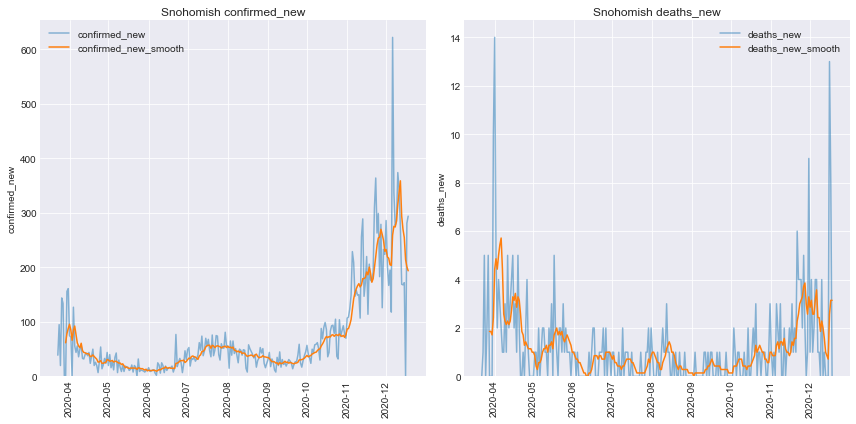

In [110]:
dfp_sno = plot_county('Washington', 'Snohomish')

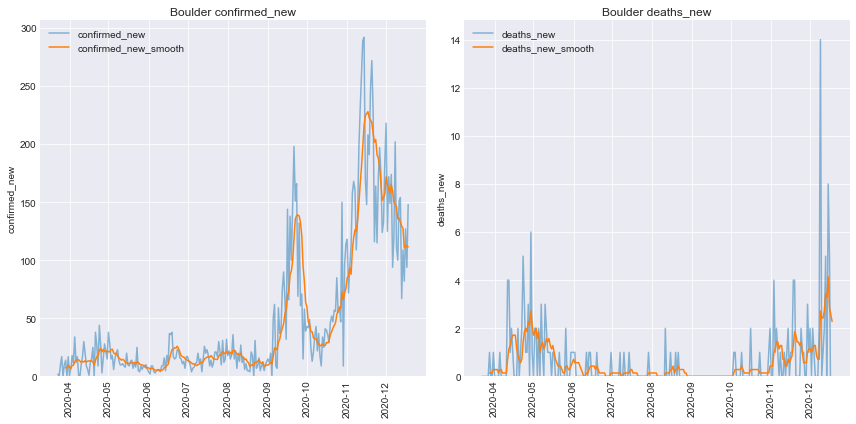

In [111]:
_ = plot_county('Colorado', 'Boulder')

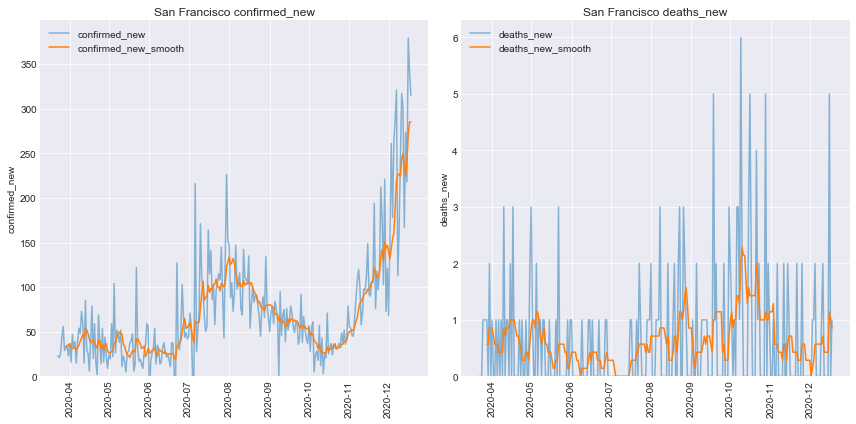

In [112]:
_ = plot_county('California', 'San Francisco')

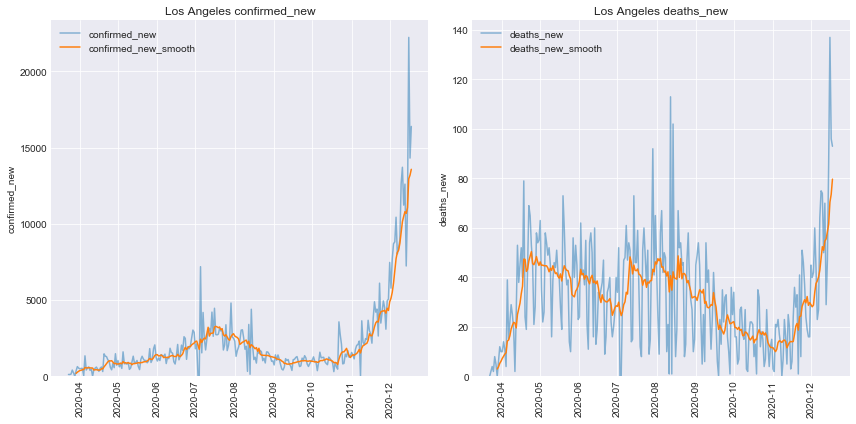

In [113]:
_ = plot_county('California', 'Los Angeles')